In [1]:
import os

os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rc, rcParams
f = mticker.ScalarFormatter(useMathText=True)
import scipy
from scipy import linalg
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.sparse import linalg
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.linalg import lu_factor
from scipy.linalg import lu_solve
import scipy.optimize as optimize
import scipy.integrate as integrate
import time

In [2]:
import sys
sys.path.append('/Users/ottaviofornieri/PHYSICS_projects/Stellar_Clusters/custom_modules/')

In [3]:
###############
# LaTeX block #
###############

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rcParams['legend.numpoints'] = 1

In [4]:
### Block to define some constants ###

conv_erg_GeV = 624.151
conv_pc_cm = 3.086e+18
conv_pc_m = 3.086e+16
conv_pc_km = 3.086e+13
conv_cm_pc = 3.24e-19
conv_yr_sec = 3.154e+7
conv_sec_yr = 3.17e-8
conv_mbarn_cm2 = 1.e-27         # Xsec conversion, millibarn to cm^2

m_p = 0.938272                  # proton mass, in [GeV c^{-2}]
m_p_grams = 1.67e-24            # proton mass, in [g]
m_e = 0.000510998918            # electron mass, in [GeV c^{-2}]
k_boltzmann = 8.617e-14         # Boltzmann constant, in [GeV K^(-1)]

# <center> 1D spherical diffusion equation
          
$$
\frac{\partial f}{\partial t} \color{Orange}{+ v \, \frac{\partial f}{\partial r}} = \color{blue}{\frac{1}{r^2} \cdot\frac{\partial}{\partial r} \left( r^2 \, D(r, p) \, \frac{\partial f}{\partial r} \right)} \color{olive}{+ \frac{1}{r^2} \frac{d \left[r^2 v(r) \right]}{dr} \frac{p}{3} \frac{\partial f}{\partial p}} \color{red}{- \frac{1}{p^2} \frac{\partial}{\partial p} \left[ p^2 \, \dot{p} \, f \right]} + S(r,p)
$$
$$ $$ $$ $$
$$
\begin{cases}
    \frac{\partial}{\partial r}\left( r^2 D(r,p) \frac{\partial f}{\partial r} - r^2 v(r) f \right) = 0\\[6pt]
    f(L, p, t) = 0 \\[6pt]
    f(r, p, 0) = 0 \\[6pt]
    f(r,p_{\mathrm{max}},t) = f(r, p_{\mathrm{min}}, t) = 0
\end{cases}
$$

In [5]:
## Set the precision when printing the numpy arrays ##

np.set_printoptions(precision=3)

In [6]:
def plot_cosmetics_single():
    
    #plt.figure(figsize=(size_hor, size_vert))
    ax = plt.gca()
    ax.tick_params(direction='in', axis='both', which='major', length=6.5, width=1.2, labelsize=18)
    ax.tick_params(direction='in', axis='both', which='minor', length=3., width=1.2, labelsize=18)
    ax.xaxis.set_tick_params(pad=7)
    ax.xaxis.labelpad = 5
    ax.yaxis.labelpad = 15
    
    
def plot_cosmetics_multi():    
    
    #plt.figure(figsize=(size_hor, size_vert))
    ax = plt.gca()
    ax.tick_params(direction='in', axis='both', which='major', length=6.5, width=1.2, labelsize=20)
    ax.tick_params(direction='in', axis='both', which='minor', length=3., width=1.2, labelsize=20)
    ax.xaxis.set_tick_params(pad=10)
    ax.xaxis.labelpad = 5
    ax.yaxis.labelpad = 10

In [7]:
## How to compute the derivative of an array, even log spaced ##

def derivative_velocity(f_array_, var_array_):
    
    der_array = np.zeros(len(var_array_), dtype=np.float64)
    for ir in range(1, len(var_array_) - 1):
        der_array[ir] = ( f_array_[ir+1] - f_array_[ir-1] ) / ( var_array_[ir+1] - var_array_[ir-1] )
        
    return der_array

## <center> Parameters of the Star Cluster
   
### Radius of the forward shock
$$
\begin{aligned}
&R_{\mathrm{FS}} (t) = 175 \, \mathrm{pc} \, \left( \frac{L_w}{10^{37} \, \mathrm{erg \cdot s^{-1}}} \right)^{1/5} \left( \frac{\rho_{\mathrm{ISM}}}{\mathrm{cm^{-3}}} \right)^{-1/5} \left( \frac{t}{10 \, \mathrm{Myr}} \right)^{3/5} \equiv L_{\mathrm{ref}} \\[6pt]
&L_w = 0.317 \cdot 10^{38} \, \mathrm{erg \cdot s^{-1}} \, \left( \frac{\dot{M}}{10^{-4} M_{\odot} \cdot \mathrm{yr}^{-1}} \right) \left( \frac{u_w}{1000 \, \mathrm{km \cdot s^{-1}}} \right)^2
\end{aligned}
$$
### Radius of the termination shock
$$
R_{\mathrm{TS}} (t) = 48.6 \, \mathrm{pc} \, \left( \frac{\dot{M}}{10^{-4} M_{\odot} \cdot \mathrm{yr}^{-1}} \right)^{3/10} \left( \frac{u_w}{1000 \, \mathrm{km \cdot s^{-1}}} \right)^{1/10} \left( \frac{\rho_{\mathrm{ISM}}}{\mathrm{cm^{-3}}} \right)^{-3/10} \left( \frac{t}{10 \, \mathrm{Myr}} \right)^{2/5}
$$
### Density of the wind, at the termination shock
$$
\begin{aligned}
\rho_{w, \mathrm{up}} = \frac{\dot{M}}{4 \pi R_{\mathrm{TS}}^2 u_{w, \mathrm{up}}} &\simeq 7.89 \cdot 10^{-4} \, \mathrm{cm}^{-3} \left( \frac{\dot{M}}{10^{-4} M_{\odot} \cdot \mathrm{yr}^{-1}} \right) \left( \frac{R_{\mathrm{TS}}}{20 \, \mathrm{pc}} \right)^{-2} \left( \frac{u_w}{1000 \, \mathrm{km \cdot s^{-1}}} \right)^{-1} \; \textrm{protons} \\[6pt]
&\simeq 1.32 \cdot 10^{-27} \, \mathrm{g \cdot cm^{-3}} \left( \frac{\dot{M}}{10^{-4} M_{\odot} \cdot \mathrm{yr}^{-1}} \right) \left( \frac{R_{\mathrm{TS}}}{20 \, \mathrm{pc}} \right)^{-2} \left( \frac{u_w}{1000 \, \mathrm{km \cdot s^{-1}}} \right)^{-1}
\end{aligned}
$$
### Magnetic field at the termination shock
$$
B(R_{\mathrm{TS}}) = 3.7 \, \mu \mathrm{G} \cdot \eta_B^{1/2} \left( \frac{\dot{M}}{10^{-4} M_{\odot} \cdot \mathrm{yr}^{-1}} \right)^{1/5} \left( \frac{u_w}{1000 \, \mathrm{km \cdot s^{-1}}} \right)^{2/5} \left( \frac{\rho_{\mathrm{ISM}}}{\mathrm{cm^{-3}}} \right)^{3/10} \left( \frac{t}{10 \, \mathrm{Myr}} \right)^{-2/5}
$$
### Magnetic field according to Hillas criterion, upstream
$$
B_{\mathrm{Hillas}}(R_{\mathrm{TS}}) \geq 0.642 \, \mu \mathrm{G} \cdot \left( \frac{p}{100 \, \mathrm{TeV}} \right) \left( \frac{1}{Z} \right) \left( \frac{20 \, \mathrm{pc}}{R_{\mathrm{TS}}} \right) \left( \frac{2500 \, \mathrm{km / s}}{u_w} \right)
$$
### Diffusion coefficient immediately upstream
#### Kolmogorov, $\alpha=5/3:$
$$
\begin{aligned}
D(p) 
    &= 5.73 \cdot 10^{27} \, \mathrm{cm^2 \cdot s^{-1}} \, \left( \frac{L_c}{1 \, \mathrm{pc}} \right)^{2/3} \eta_{B}^{-1/6} \left( \frac{\dot{M}}{10^{-4} M_{\odot} \cdot \mathrm{yr}^{-1}} \right)^{-1/15} \left( \frac{u_w}{1000 \, \mathrm{km \cdot s^{-1}}} \right)^{-2/15} \left( \frac{\rho_{\mathrm{ISM}}}{\mathrm{cm^{-3}}} \right)^{-1/10} \left( \frac{t}{10 \, \mathrm{Myr}} \right)^{2/15} \left( \frac{1}{Z} \right)^{1/3} \left( \frac{p}{10 \, \mathrm{TeV}} \right)^{1/3} \\ 
    &\equiv D^{\mathrm{Kol}}_0 \cdot \left( \frac{p}{10 \, \mathrm{TeV}} \right)^{1/3}
\end{aligned}\\[10pt]
$$
    
#### Kraichnan, $\alpha=3/2:$
$$
\begin{aligned}
D(p) 
    &= 2.47 \cdot 10^{27} \, \mathrm{cm^2 \cdot s^{-1}} \, \left( \frac{L_c}{1 \, \mathrm{pc}} \right)^{1/2} \eta_{B}^{-1/4} \left( \frac{\dot{M}}{10^{-4} M_{\odot} \cdot \mathrm{yr}^{-1}} \right)^{-1/10} \left( \frac{u_w}{1000 \, \mathrm{km \cdot s^{-1}}} \right)^{-1/5} \left( \frac{\rho_{\mathrm{ISM}}}{\mathrm{cm^{-3}}} \right)^{-3/20} \left( \frac{t}{10 \, \mathrm{Myr}} \right)^{1/5} \left( \frac{1}{Z} \right)^{1/2} \left( \frac{p}{10 \, \mathrm{TeV}} \right)^{1/2} \\ 
    &\equiv D^{\mathrm{IK}}_0 \cdot \left( \frac{p}{10 \, \mathrm{TeV}} \right)^{1/2}
\end{aligned}\\[10pt]
$$
        
#### Bohm, $\alpha=1:$
$$
\begin{aligned}
D(p) 
    &= 1.98 \cdot 10^{26} \, \mathrm{cm^2 \cdot s^{-1}} \, \eta_{B}^{-1/2} \left( \frac{\dot{M}}{10^{-4} M_{\odot} \cdot \mathrm{yr}^{-1}} \right)^{-1/5} \left( \frac{u_w}{1000 \, \mathrm{km \cdot s^{-1}}} \right)^{-2/5} \left( \frac{\rho_{\mathrm{ISM}}}{\mathrm{cm^{-3}}} \right)^{-3/10} \left( \frac{t}{10 \, \mathrm{Myr}} \right)^{2/5} \left( \frac{1}{Z} \right) \left( \frac{p}{10 \, \mathrm{TeV}} \right) \\ 
    &\equiv D^{\mathrm{Bohm}}_0 \cdot \left( \frac{p}{10 \, \mathrm{TeV}} \right)
\end{aligned}\\[10pt]
$$
    
    
$$
\begin{aligned}
&L_c \equiv \textrm{coherence length of the magnetic field} \\
&\eta_B \equiv \textrm{conversion efficiency of the wind kinetic energy into turbulent magnetic field}
\end{aligned}
$$

radius of the forward shock (FS), L_ref = 96.24941956816512 [pc]
radius of the termination shock (TS) = 15.30096963551336 [pc]
magnetic field at the TS = 7.616293739207874 [muG]
magnetic field according to Hillas criterion: B > 5.994017888998225 [muG]
diffusion coefficient at 10 TeV, D_0 = 2.4346748554345995e+27 [cm^2 / s]
wind luminosity at the TS = 3.727919999999999e+38 [erg / s]
wind density at the TS = 1.2081733273340754e-27 [g / cm^3] = 0.0007234570822359733 protons / cm^3

ram pressure of the wind = 5.912007508962501e-08 [GeV / cm^3]
energy budget injected by the source, available for CR acceleration = 3.5273579039999986e+52 [erg]


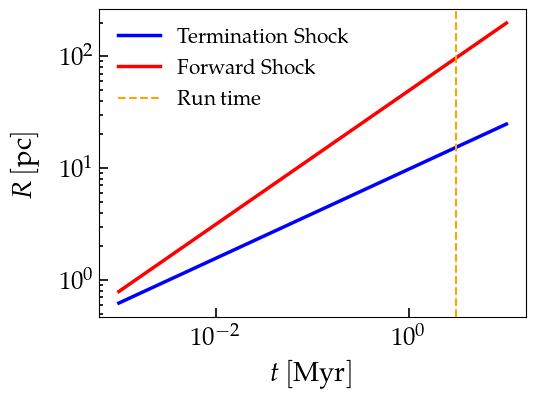

In [8]:
## Paramters of the problem ##

n_ISM = 20.                               # density between the termination shock (TS) and the forward shock (FS), in [cm^{-3}]
M_dot = 1.5e-4                            # mass-loss rate, in [M_sun yr^{-1}]
v_0 = 2800.                               # wind velocity at the TS, in [km s^{-1}]
eta_B = 0.1                               # conversion effiency into turbulent B
L_c = 2.                                  # coherence length of the cluster field, in [pc]
delta_diff = 0.5
Z = 1                                     # atomic number, Z=1 for protons
p_max_cluster = 800.e3                    # 800 TeV, corresponding to a maximum 100 TeV photons, in [GeV]


t_physical_yr = 3.e+6                    # required duration of the run, in [yr]
t_physical_Myr = t_physical_yr / 1.e+6    # same, in [Myr]


# magnetic field at the termination shock, in [muG]
B_TS = 3.7 * eta_B**(1/2) * (M_dot / 1.e-4)**(1/5) * (v_0 / 1.e3)**(2/5) * (n_ISM / 1.)**(3/10) * (t_physical_Myr / 10.)**(-2/5)

# wind luminosity, in [erg / s]
L_wind = 0.317e38 * (M_dot / 1.e-4) * (v_0 / 1.e3)**2
E_budget_CR = L_wind * t_physical_yr*conv_yr_sec   # energy budget into CRs, in [erg]
E_budget_CR_GeV = E_budget_CR * conv_erg_GeV

# reference length-scale, corresponding to the radius of the FS, in [pc]
L_ref = 175. * (L_wind / 1.e37)**(1/5) * (n_ISM / 1.)**(-1/5) * (t_physical_Myr / 10.)**(3/5)
def L_ref_func(t_):
    return 175. * (L_wind / 1.e37)**(1/5) * (n_ISM / 1.)**(-1/5) * (t_ / 10.)**(3/5)

# radius of the termination shock, in [pc]
R_TS = 48.6 * (M_dot / 1.e-4)**(3/10) * (v_0 / 1.e3)**(1/10) * (n_ISM / 1.)**(-3/10) * (t_physical_Myr / 10.)**(2/5)
def R_TS_func(t_):
    return 48.6 * (M_dot / 1.e-4)**(3/10) * (v_0 / 1.e3)**(1/10) * (n_ISM / 1.)**(-3/10) * (t_ / 10.)**(2/5)


# ram pressure of the wind, in [GeV / cm^3]
rho_wind_TS = 1.32e-27 * (M_dot / 1.e-4) * (R_TS / 20.)**(-2) * (v_0 / 1.e3)**(-1)       # in [g / cm^3]
ram_pressure_TS_erg = rho_wind_TS * (v_0 * 1.e5)**2                                      # in [erg / cm^3]
ram_pressure_TS_GeV = ram_pressure_TS_erg * conv_erg_GeV

# magnetic field according to Hillas criterion, in [muG]
B_Hillas = 0.642 * (p_max_cluster / 1.e5) * (1. / Z) * (20. / R_TS) * (2500. / v_0)

# diffusion coefficient immediately upstream, in [cm^2 / s]
if delta_diff == 0.:
    compr_diff_downstream = 1.                # D_upstream / D_downstream
    D_0 = 3.086e28 * (L_c / 1.)

elif delta_diff == 0.33:
    compr_diff_downstream = 0.67              # D_upstream / D_downstream
    D_0 = 5.73e27 * (L_c / 1.)**(2/3) * eta_B**(-1/6) * (M_dot / 1.e-4)**(-1/15) * (v_0 / 1.e3)**(-2/15) * (n_ISM / 1.)**(-1/10) * (t_physical_Myr / 10.)**(2/15) * (1 / Z)**(1/3)

elif delta_diff == 0.5:
    compr_diff_downstream = 0.55              # D_upstream / D_downstream
    D_0 = 2.47e27 * (L_c / 1.)**(1/2) * eta_B**(-1/4) * (M_dot / 1.e-4)**(-1/10) * (v_0 / 1.e3)**(-1/5) * (n_ISM / 1.)**(-3/20) * (t_physical_Myr / 10.)**(1/5) * (1 / Z)**(1/2)
    
elif delta_diff == 1.:
    compr_diff_downstream = 0.3               # D_upstream / D_downstream
    D_0 = 1.98e26 * eta_B**(-1/2) * (M_dot / 1.e-4)**(-1/5) * (v_0 / 1.e3)**(-2/5) * (n_ISM / 1.)**(-3/10) * (t_physical_Myr / 10.)**(2/5) * (1 / Z)
    
    

plt.figure(figsize=(5.5, 4.))
plot_cosmetics_single()

t_radius_Myr = np.logspace(start=-3., stop=1., num=100)
plt.loglog(t_radius_Myr, R_TS_func(t_radius_Myr), lw=2.5, color='blue', label='Termination Shock')
plt.loglog(t_radius_Myr, L_ref_func(t_radius_Myr), lw=2.5, color='red', label='Forward Shock')
plt.axvline(x=t_physical_Myr, ls='--', lw=1.5, color='orange', label='Run time')
plt.xlabel('$t \, [{\mathrm{Myr}}]$', fontsize=20)
plt.ylabel('$R \,  [{\mathrm{pc}}]$', fontsize=20)
plt.legend(fontsize=15, frameon=False, loc='best')
    

print(f'radius of the forward shock (FS), L_ref = {L_ref} [pc]')
print(f'radius of the termination shock (TS) = {R_TS} [pc]')
print(f'magnetic field at the TS = {B_TS} [muG]')
print(f'magnetic field according to Hillas criterion: B > {B_Hillas} [muG]')
print(f'diffusion coefficient at 10 TeV, D_0 = {D_0} [cm^2 / s]')
print(f'wind luminosity at the TS = {L_wind} [erg / s]')
print(f'wind density at the TS = {rho_wind_TS} [g / cm^3] = {rho_wind_TS / m_p_grams} protons / cm^3')
print('')
print(f'ram pressure of the wind = {ram_pressure_TS_GeV} [GeV / cm^3]')
print(f'energy budget injected by the source, available for CR acceleration = {E_budget_CR} [erg]')


radius of the forward shock (FS), L_ref = 96.24941956816512 [pc]
radius of the termination shock (TS) = 15.30096963551336 [pc]

number of sections in which we divided the space: 6.290413082369069
acceleration length: 0.29270479043629344, left space: -0.1337327186652319
dimensionless location of the shock: 0.15897207177106154
DeltaX_acc minimum = 0.1584265443623284 [pc], DeltaX_acc maximum = 28.172666184314654 [pc]
dimensionless DeltaX_acc minimum = 0.0016459999974350868, dimensionless DeltaX_acc maximum = 0.29270479043629344
factors below the minimum acceleration scale = 4.0, 1.0
necessary dimensionless dx = 0.0004114999993587717, necessary Nx with a uniform grid = 2430
Nx around the shock (left) = 386, Nx around the shock (right) = 711, Nx away from the shock (left) = 2, Nx away from the shock (right) = 83, total Nx = 1182
min physical space-step: 0.0396066360905821 [pc]
max physical space-step: 0.1584265443623284 [pc]

length of the non-uniform grid (Nx) = 1180
first grid point = 0.0

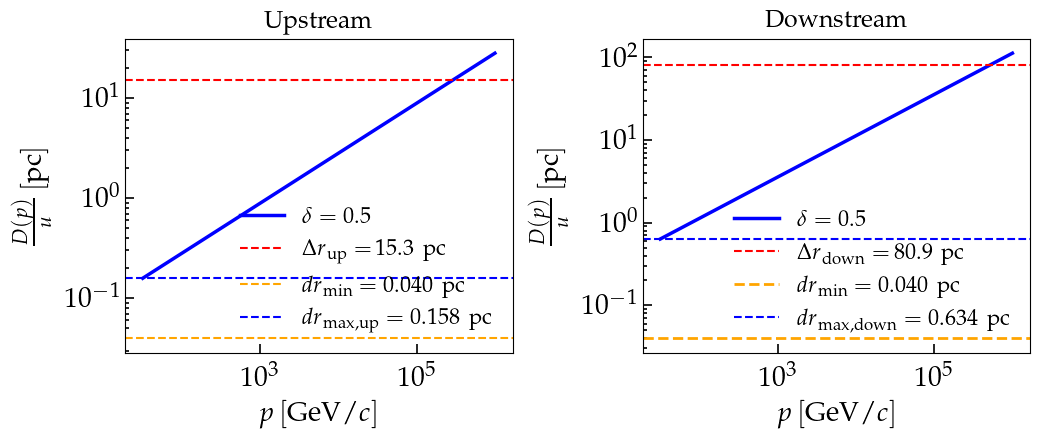

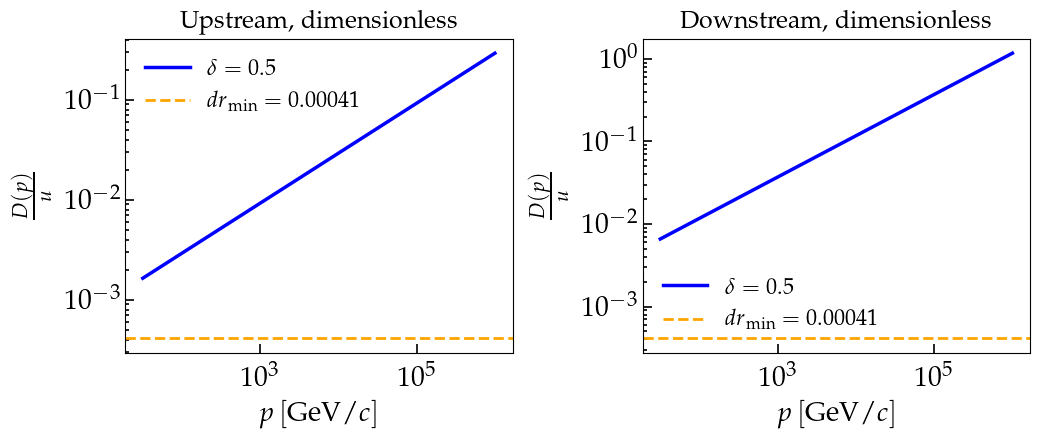

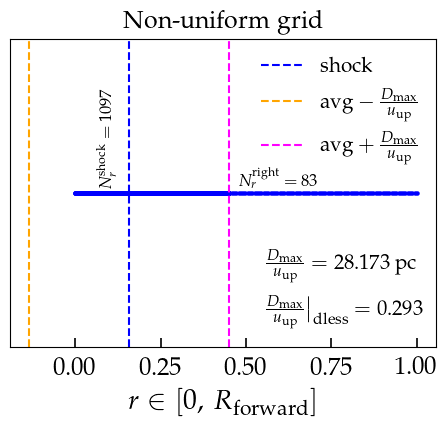

In [9]:
### Block for preliminary assignments ###


n_op = 2                 # number of variables in the PDE
L = 1.


# momentum grid
Np = 4096
p_grid = np.logspace(start=1.5, stop=6., num=Np+1)       # in [GeV]
deltap_over_p = [ (p_grid[ip+1] - p_grid[ip]) / p_grid[ip] for ip in range(len(p_grid)-1) ]
p_lower1 = p_grid[0] / ( 1 + deltap_over_p[0] )           # ghost momentum, lower
p_higher1 = p_grid[-1] * ( 1 + deltap_over_p[0] )         # ghost momentum, upper
dp_min = np.min([p_grid[ip+1] - p_grid[ip] for ip in range(len(p_grid)-1)])
p_ref = 1.                                                # reference momentum, in [GeV]



# Building the diffusion coefficient: D(p) = D_0*(p/p_0)^delta #
################################################################
p_0_diff = 1.e+4                 # in [GeV]

def D_coeff_func(p_):
    return D_0 * (p_ / p_0_diff)**delta_diff

D_ref = np.min(D_coeff_func(p_grid))
pdot_ref = p_ref / ( (L_ref*conv_pc_cm)**2 / D_ref )
################################################################


# velocity of the wind, for advection
#####################################
v_0_cm = v_0*1.e5                                 # in [cm s^{-1}]
v_dless = v_0_cm * (L_ref*conv_pc_cm) / D_ref     # dimensionless velocity upstream
compr_factor = 4.                                 # compression factor at the shock
DeltaL_v = 0.1 * L_ref                            # step for the change in the velocity profile, in [pc]
DeltaL_v_dless = DeltaL_v / L_ref
#####################################


DeltaX_acc_up = D_coeff_func(p_grid) / v_0_cm * conv_cm_pc                      # acceleration length upstream
DeltaX_acc_down = D_coeff_func(p_grid) / (v_0_cm/compr_factor) * conv_cm_pc     # acceleration length downstream
factor_below_DeltaXAcc_maxDx = 1.
factor_below_DeltaXAcc_minDx = 4.
DeltaX_acc_min = min( min(DeltaX_acc_up), min(DeltaX_acc_down) )
DeltaX_acc_max = max(D_coeff_func(p_grid)) / v_0_cm * conv_cm_pc
DeltaX_acc_min_dless = DeltaX_acc_min / L_ref
DeltaX_acc_max_dless = DeltaX_acc_max / L_ref
necessary_dx = DeltaX_acc_min_dless / factor_below_DeltaXAcc_minDx
necessary_Nx = int( L/necessary_dx )
width_at_shock = 2         # region with the finest coarse, around the shock, width_at_shock/2 + width_at_shock/2, in dimensionless units D/u
dx_min = necessary_dx
dx_max = DeltaX_acc_min_dless / factor_below_DeltaXAcc_maxDx
dx_max_down = (min(DeltaX_acc_down) / L_ref) / factor_below_DeltaXAcc_maxDx
dx_physical_min = dx_min * L_ref                          # minimum spatial step, in [pc]
dx_physical_max = dx_max * L_ref                          # maximum spatial step, in [pc]
dx_physical_max_down = dx_max_down * L_ref                # maximum spatial step downstream, in [pc]


num_sections = L_ref / R_TS                               # number of sections to slice the spatial grid
start_x_grid_slices = 0.                                  # starting point of the space grid
shock_location = start_x_grid_slices + L/num_sections     # location of the shock, in terms of slices of the grid
left_space = shock_location - DeltaX_acc_max_dless * (width_at_shock/2)
right_space = L - (shock_location + DeltaX_acc_max_dless * (width_at_shock/2))



if left_space >= 0.:
    Nx_around_shock_left = round(DeltaX_acc_max_dless * (width_at_shock/2) / dx_min)
    Nx_around_shock_right = Nx_around_shock_left
    Nx_away_from_shock_left = round(left_space / dx_max)
else:
    Nx_around_shock_left = round((shock_location - start_x_grid_slices) / dx_min)
    Nx_around_shock_right = round(DeltaX_acc_max_dless * (width_at_shock/2) / dx_min)
    Nx_away_from_shock_left = 0
    
if Nx_away_from_shock_left == 0: Nx_away_from_shock_left = 2
Nx_away_from_shock_right = round(right_space / dx_max_down)
if Nx_away_from_shock_right < 5: Nx_away_from_shock_right = 5


print(f'radius of the forward shock (FS), L_ref = {L_ref} [pc]')
print(f'radius of the termination shock (TS) = {R_TS} [pc]')
print('')
print(f'number of sections in which we divided the space: {num_sections}')
print(f'acceleration length: {DeltaX_acc_max_dless * (width_at_shock/2)}, left space: {left_space}')
print(f'dimensionless location of the shock: {shock_location}')
print(f'DeltaX_acc minimum = {DeltaX_acc_min} [pc], DeltaX_acc maximum = {DeltaX_acc_max} [pc]')
print(f'dimensionless DeltaX_acc minimum = {DeltaX_acc_min_dless}, dimensionless DeltaX_acc maximum = {DeltaX_acc_max_dless}')
print(f'factors below the minimum acceleration scale = {factor_below_DeltaXAcc_minDx}, {factor_below_DeltaXAcc_maxDx}')
print(f'necessary dimensionless dx = {necessary_dx}, necessary Nx with a uniform grid = {necessary_Nx}')
print(f'Nx around the shock (left) = {Nx_around_shock_left}, Nx around the shock (right) = {Nx_around_shock_right}, Nx away from the shock (left) = {Nx_away_from_shock_left}, Nx away from the shock (right) = {Nx_away_from_shock_right}, total Nx = {Nx_around_shock_left + Nx_around_shock_right + Nx_away_from_shock_left + Nx_away_from_shock_right}')
print(f'min physical space-step: {dx_physical_min} [pc]')
print(f'max physical space-step: {dx_physical_max} [pc]')
print('')



plt.figure(figsize=(10.5, 4.5))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

plt.title('Upstream', fontsize=18, pad=8)
plt.loglog(p_grid, DeltaX_acc_up, lw=2.5, color='blue', label='$\\delta = \;$' + str(delta_diff)) 
plt.xlabel('$ p \, [\mathrm{GeV}/c]$',fontsize=20)
plt.ylabel('$\\frac{D(p)}{u} \, [\mathrm{pc}]$',fontsize=20)
plt.axhline(y=shock_location*L_ref, ls='--', lw=1.5, color='red', label='$\\Delta r_{\mathrm{up}} = \,$' + str("{:.1f}".format((shock_location)*L_ref)) + '\, pc')
plt.axhline(y=dx_physical_min, ls='--', lw=1.5, color='orange', label='$dr_{\mathrm{min}} = \;$' + str("{:.3f}".format(dx_physical_min)) + '\, pc')
plt.axhline(y=dx_physical_max, ls='--', lw=1.5, color='blue', label='$dr_{\mathrm{max, up}} = \;$' + str("{:.3f}".format(dx_physical_max)) + '\, pc')
plt.legend(fontsize=16, frameon=False)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

plt.title('Downstream', fontsize=18, pad=8)
plt.loglog(p_grid, DeltaX_acc_down, lw=2.5, color='blue', label='$\\delta = \;$' + str(delta_diff))
plt.xlabel('$ p \, [\mathrm{GeV}/c]$',fontsize=20)
plt.ylabel('$\\frac{D(p)}{u} \, [\mathrm{pc}]$',fontsize=20)
plt.axhline(y=(L-shock_location)*L_ref, ls='--', lw=1.5, color='red', label='$\\Delta r_{\mathrm{down}} = \,$' + str("{:.1f}".format((L-shock_location)*L_ref)) + '\, pc')
plt.axhline(y=dx_physical_min, ls='--', lw=2., color='orange', label='$dr_{\mathrm{min}} = \;$' + str("{:.3f}".format(dx_physical_min)) + '\, pc')
plt.axhline(y=dx_physical_max_down, ls='--', lw=1.5, color='blue', label='$dr_{\mathrm{max, down}} = \;$' + str("{:.3f}".format(dx_physical_max_down)) + '\, pc')
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()


# dimensionless version
plt.figure(figsize=(10.5, 4.5))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

plt.title('Upstream, dimensionless', fontsize=18, pad=8)
plt.loglog(p_grid, DeltaX_acc_up / L_ref, lw=2.5, color='blue', label='$\\delta = \;$' + str(delta_diff))
plt.xlabel('$ p \, [\mathrm{GeV}/c]$',fontsize=20)
plt.ylabel('$\\frac{D(p)}{u}$',fontsize=20)
plt.axhline(y=dx_min, ls='--', lw=2., color='orange', label='$dr_{\mathrm{min}} = \;$' + str("{:.5f}".format(dx_min)))
plt.legend(fontsize=16, frameon=False)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

plt.title('Downstream, dimensionless', fontsize=18, pad=8)
plt.loglog(p_grid, DeltaX_acc_down / L_ref, lw=2.5, color='blue', label='$\\delta = \;$' + str(delta_diff))
plt.xlabel('$ p \, [\mathrm{GeV}/c]$',fontsize=20)
plt.ylabel('$\\frac{D(p)}{u}$',fontsize=20)
plt.axhline(y=dx_min, ls='--', lw=2., color='orange', label='$dr_{\mathrm{min}} = \;$' + str("{:.5f}".format(dx_min)))
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()



# non-uniform space grid #
##########################
start_x_grid = start_x_grid_slices
x_around_shock = DeltaX_acc_max_dless * (width_at_shock/2)
stop_x_grid = start_x_grid + L

if left_space >= 0.:
    x_grid = np.r_[np.linspace(start_x_grid, left_space, Nx_away_from_shock_left, endpoint=False), 
               np.linspace(left_space, shock_location + DeltaX_acc_max_dless * (width_at_shock/2), Nx_around_shock_left + Nx_around_shock_right, endpoint=False),
               np.linspace(shock_location + DeltaX_acc_max_dless * (width_at_shock/2), stop_x_grid, Nx_away_from_shock_right, endpoint=True)]
else:
    x_grid = np.r_[np.linspace(start_x_grid, shock_location, Nx_around_shock_left, endpoint=False), 
               np.linspace(shock_location, shock_location + DeltaX_acc_max_dless * (width_at_shock/2), Nx_around_shock_right, endpoint=False),
               np.linspace(shock_location + DeltaX_acc_max_dless * (width_at_shock/2), stop_x_grid, Nx_away_from_shock_right, endpoint=True)]
    
    

x_grid = np.asarray(x_grid)
dx_array = [(x_grid[ix+1] - x_grid[ix]) for ix in range(0, len(x_grid)-1)]
Nx = len(x_grid) - 1
dx_min_nu = min(dx_array)
dx_low = x_grid[1] - x_grid[0]
dx_up = x_grid[-1] - x_grid[-2]
shock_index = np.argmin( abs(shock_location - x_grid) )


print(f'length of the non-uniform grid (Nx) = {len(x_grid)}')
print(f'first grid point = {x_grid[0]}, last grid point = {x_grid[-1]}')
print(f'shock_index: {shock_index}, x_grid[shock_index] = {x_grid[shock_index]} = {x_grid[shock_index]*L_ref} [pc]')
print(f'minimum dx = {dx_min}, maximum dx = {dx_max}')
print(f'minimum dx in the non-uniform grid = {dx_min_nu}')
print('')


plt.figure(figsize=(5.5, 4.))
plot_cosmetics_single()


plt.title('Non-uniform grid', fontsize=18, pad=8)
plt.scatter(x_grid, [1. for i in x_grid], s=5, color='blue')
plt.axvline(x=shock_location, ls='--', lw=1.5, color='blue', label='shock')
plt.axvline(x=shock_location-width_at_shock/2 * DeltaX_acc_max_dless, ls='--', lw=1.5, color='Orange', label='$\mathrm{avg} - \\frac{D_{\mathrm{max}}}{u_{\mathrm{up}}}$')
plt.axvline(x=shock_location+width_at_shock/2 * DeltaX_acc_max_dless, ls='--', lw=1.5, color='magenta', label='$\mathrm{avg} + \\frac{D_{\mathrm{max}}}{u_{\mathrm{up}}}$')
plt.xlabel('$r \in [0, \, R_{\mathrm{forward}}]$', fontsize=20)
plt.yticks([])
plt.legend(fontsize=15, frameon=False, loc='upper right')
plt.text(0.6, 0.1, '$\\frac{D_{\mathrm{max}}}{u_{\mathrm{up}}}\\big|_{\mathrm{dless}} = \;$' + str("{:.3f}".format(DeltaX_acc_max_dless)), fontsize=15, transform = plt.gca().transAxes)
plt.text(0.6, 0.25, '$\\frac{D_{\mathrm{max}}}{u_{\mathrm{up}}} = \;$' + str("{:.3f}".format(DeltaX_acc_max)) + '$\, \mathrm{pc}$', fontsize=15, transform = plt.gca().transAxes)
plt.text(shock_location - 0.6*shock_location, 1.003, '$N_r^{\mathrm{shock}} = \,$' + str(Nx_around_shock_left+Nx_around_shock_right), fontsize=12, rotation=90)
plt.text(shock_location + 1.1*width_at_shock/2 * DeltaX_acc_max_dless, 1.003, '$N_r^{\mathrm{right}} = \,$' + str(Nx_away_from_shock_right), fontsize=12, rotation=0)
if left_space > 0.:
    plt.text(shock_location - 1.1*width_at_shock/2 * DeltaX_acc_max_dless, 1.003, '$N_r^{\mathrm{left}} = \,$' + str(Nx_away_from_shock_left), fontsize=12, rotation=90)

plt.savefig('NonUniform_Grid.pdf',format='pdf',bbox_inches='tight', dpi=200)
##########################

# creating the D(E) at each point in space
D_matrix = np.zeros( (len(x_grid), len(p_grid)), dtype=np.float64 )
D_matrix_dless = np.zeros( (len(x_grid), len(p_grid)), dtype=np.float64 )


for ix in range(len(x_grid)):
    if ix <= shock_index:
        D_matrix[ix, :] = D_coeff_func(p_grid[:]) * ( R_TS / ( R_TS + abs(R_TS - x_grid[ix]*L_ref) ) )**(delta_diff)
    else:
        D_matrix[ix, :] = D_coeff_func(p_grid[:]) * compr_diff_downstream
        
    D_matrix_dless[ix, :] = D_matrix[ix, :] / D_ref

    
# linear extrapolation of the diffusion-coefficient matrix one point above and below the space grid
D_SpaceSlope_up = (D_matrix[-1, 0] - D_matrix[-2, 0]) / dx_up
D_SpaceSlope_low = (D_matrix[1, 0] - D_matrix[0, 0]) / dx_low
D_higher1 = [D_matrix[-1, 0] + D_SpaceSlope_up * dx_up for ip in range(len(p_grid))]
D_lower1 = [D_matrix[0, 0] - D_SpaceSlope_low * dx_low for ip in range(len(p_grid))]



## velocity profiles, for advection ##
######################################
#case_velocity = 'spherical_velocity_SolarWind'
case_velocity = 'spherical_velocity'

def v_profile_func(x_):
    
    v_profile = np.zeros(len(x_), dtype=np.float64)
    
    if case_velocity == 'symmetric_velocity':
        center = x_[shock_index]
        dist_from_center = DeltaL_v_dless
        indx_temp = [ix for ix in range(len(x_)) if (abs(x_[ix] - center) <= dist_from_center)]

        for ix in range(len(x_)):
            if (abs(x_[ix] - center) > dist_from_center):
                v_profile[ix] = v_dless * (1./( abs(x_[max(indx_temp)+1] - center) )**(-2)) * ( abs(x_[ix] - center) )**(-2)
            else:
                v_profile[ix] = v_dless
                
        label_v_profile = '$v(x) = v_{0} \cdot \\left( \\frac{x - x_{\mathrm{inj}}}{\\Delta x_{v}} \\right)^{-2}$'
    
        
    elif case_velocity == 'spherical_velocity':
        shock_loc = x_[shock_index]
        
        for ix in range(0, len(x_)):
            if ix < shock_index:
                v_profile[ix] = v_dless
            else:
                v_profile[ix] = v_dless/compr_factor * ( x_[ix] / shock_loc )**(-2)
                
        label_v_profile = 'Spherical_Cluster'
        
        
    elif case_velocity == 'spherical_velocity_modified':
        shock_loc = x_[shock_index]
        
        for ix in range(1, len(x_)):
            if ix < shock_index:
                v_profile[ix] = v_dless * ( x_[ix] / shock_loc )**(2)
            else:
                v_profile[ix] = v_dless/compr_factor * ( x_[ix] / shock_loc )**(-2)
                
        v_profile[0] = v_profile[1]
        label_v_profile = 'Spherical_Cluster_Modified'
        
        
    elif case_velocity == 'spherical_velocity_SolarWind':
        shock_loc = x_[shock_index]
        v_dless_initial = v_dless/4
        m_slope = (v_dless - v_dless_initial) / (shock_loc - 0)
        
        v_profile[0] = v_dless_initial
        
        for ix in range(1, len(x_)):
            if ix < shock_index:
                v_profile[ix] = v_profile[ix-1] + m_slope * ( x_[ix] -  x_[ix-1] )
            else:
                v_profile[ix] = v_dless/compr_factor * ( x_[ix] / shock_loc )**(-2)
                
        label_v_profile = 'Spherical_Cluster_SolarWind'
        
        
    elif case_velocity == 'step_function':
        shock_loc = x_[shock_index]
        v_profile = [v_dless / compr_factor if x_[ix] >= shock_loc else v_dless for ix in range(len(x_))]
        label_v_profile = 'Step function'
        
        
    elif case_velocity == 'tanh_step_function':
        ## to be corrected: the tanh is centered at the central point of the grid ##
        center = x_[shock_index]
        v_profile = [v_dless/2 * (1 + np.tanh(-x_[ix] / (dx))) + v_dless/(2*compr_factor) * (1 + np.tanh(x_[ix] / (dx))) for ix in range(len(x_))]
        label_v_profile = 'tanh'
        
        
    elif case_velocity == 'Galactic':
        center = x_[len(x_)//2]
        v_profile = [v_dless * np.tanh(x_[ix] / (dx)) for ix in range(len(x_))]
        label_v_profile = 'Galactic'
        
            
    elif case_velocity == 'constant_velocity':
        v_profile = [v_dless for ix in range(len(x_))]
        label_v_profile = '$v(x) = v_0$'
        
        
    elif case_velocity == 'linear_growth_velocity':
        v_profile = [v_dless + v_dless * ( abs( x_[ix] - min(x_) ) / DeltaL_v_dless ) for ix in range(len(x_))]
        label_v_profile = '$v(x) = v_0 \cdot \\left( \\frac{x}{\\Delta x_{v}} \\right)$'
        
        
    elif case_velocity == 'quadratic_growth_velocity':
        v_profile = [v_dless + v_dless * ( abs( x_[ix] - min(x_) ) / DeltaL_v_dless )**(2.) for ix in range(len(x_))]
        label_v_profile = '$v(x) = v_0 \cdot \\left( \\frac{x}{\\Delta x_{v}} \\right)^2$'
            
            
    return v_profile, label_v_profile



label_v_profile = v_profile_func(x_grid)[1]
v_adv = v_profile_func(x_grid)[0]
v_adv_Rsquare = v_adv * x_grid**2
v_adv_derivative = derivative_velocity(v_profile_func(x_grid)[0], x_grid)
v_adv_derivative_Rsquare = derivative_velocity(v_adv_Rsquare, x_grid)
######################################



## profile of the densities ##
##############################

# wind density
def wind_density(r_):
    return (rho_wind_TS / m_p_grams) * ( r_ / (R_TS/L_ref) )**(-2)   # in [particles / cm^3]


wind_density_array = np.zeros( len(x_grid) )
for ix in range(len(x_grid)):
    if x_grid[ix] <= (L_c/L_ref):
        wind_density_array[ix] = wind_density(x_grid[ np.argmin( abs(x_grid - L_c/L_ref) ) ])
    else:
        wind_density_array[ix] = wind_density(x_grid[ix])
        
        
# density of the ISM
n_ISM_array = np.zeros(len(x_grid), dtype=np.float64)
for ix in range(len(x_grid)):
    if ix < shock_index:
        n_ISM_array[ix] = n_ISM / compr_factor
    else:
        n_ISM_array[ix] = n_ISM
##############################

## <center> Magnetic field and Relativistic energy losses
        
### Leptons
    
$$
\frac{dp}{dt} (p, r) = - \frac{4}{3} \sigma_\mathrm{T} c \, \left[ U_B + f_{\mathrm{KN}} \cdot U_{\mathrm{ISRF}} \right] \cdot \left( \frac{p}{m_e c} \right)^2 \qquad \qquad
\begin{cases}
\sigma_\mathrm{T} = 6.65 \cdot 10^{-25} \, \mathrm{cm^2} \\
\displaystyle{\frac{B^2}{8 \pi} = 0.223 \cdot 10^{-9} \, \frac{\mathrm{GeV}}{\mathrm{cm^3}} \cdot \left( \frac{B}{3 \, \mu \mathrm{G}} \right)^2}
\end{cases}
$$
    
#### $\qquad \qquad$ Synchrotron only (example):
    
$$
\frac{dp}{dt} \bigg\vert_{\mathrm{Syn}} \simeq 0.23 \cdot 10^{-16} \, \frac{\mathrm{GeV}}{\mathrm{s}} \cdot \left( \frac{p}{1 \, \mathrm{GeV}/c} \right)^2 \left( \frac{B}{3 \, \mu \mathrm{G}} \right)^2
$$
    
### Hadrons
    
$$
\frac{dp}{dt} (p, r) = - 5.1 \cdot 10^{-15} K_{\pi} n_{\mathrm{gas}}(r) \left( \frac{p}{1 \, \mathrm{GeV}/c} \right) \cdot \left[ 1 + 5.5 \cdot 10^{-2} L + 7.3 \cdot 10^{-3} L^2 \right] \, \mathrm{GeV \cdot s^{-1}}
\qquad \qquad 
\begin{cases}
L \equiv \ln \left( \frac{p}{10^3 \mathrm{GeV}/c} \right) \\
K_{\pi} = 0.13
\end{cases}
$$
    


** Example **

B field = 7.616293739207874 [muG], magnetic energy density = 1.440579337878644e-09 [GeV cm^{-3}]

E*tau at 100.0 [GeV/c]: 138.45089188789225 [GeV/c Myr]
Loss timescale = 43675360217000.7 [s] = 1.3845089188789221 [Myr]
Diffusive distance for 100.0 [GeV] leptons = 56.185690483259954 [pc]



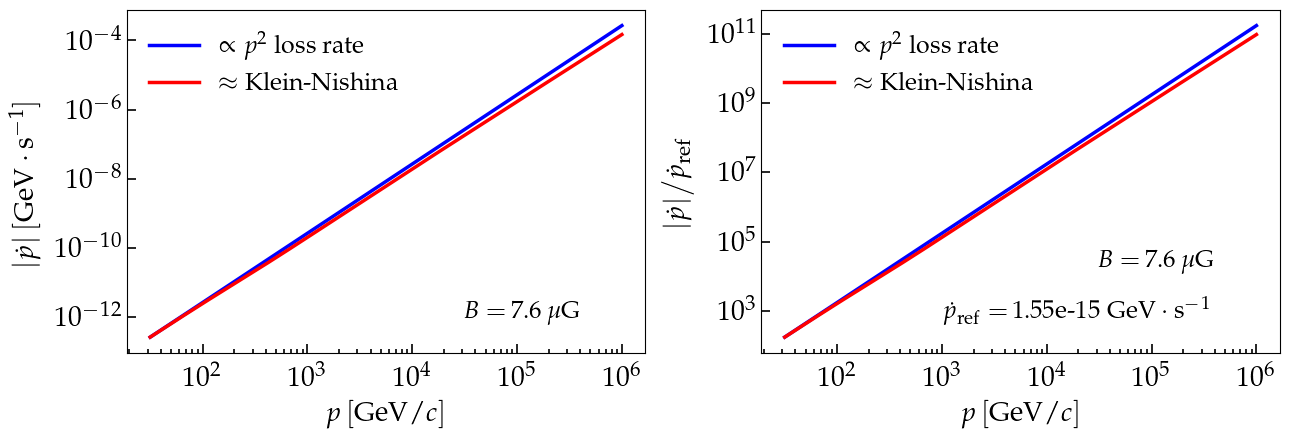

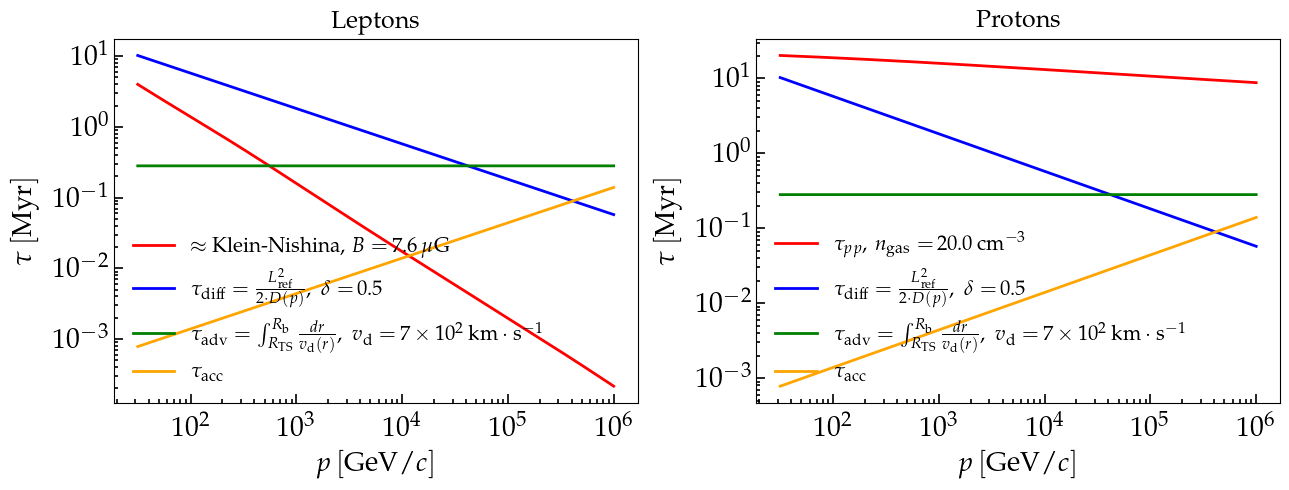

In [10]:
### Block to define the rate of momentum loss, computed in CGS base units ###
# Klein-Nishina factor from Evoli et al. arXiv:2007.01302 (2020) #


ISRF_components = ['CMB', 'IR', 'OPT', 'UV_1', 'UV_2', 'UV_3']
T_ISRF = [2.725, 33.07, 313.32, 3249.3, 6150.4, 23209.0]            # in [K]
U_ISRF = [0.26e-9, 0.25e-9, 0.055e-9, 0.37e-9, 0.23e-9, 0.12e-9]    # energy density of the contributions, in [GeV cm^(-3)]

sigma_Thomson = 6.65e-25                             # in [cm^2]
c_cm = 2.99e+10                                      # speed of light, in [cm s^(-1)]
factor_ratio = ( 45 / (64*np.pi**2) )


# Leptons
def loss_rate_KN(momentum_, B_):
# momentum variable in [GeV], B field in [muG], => result in [GeV * s^{-1}]
    
    f_KN_times_U = 0.
    for i in range (len(T_ISRF)):

        f_KN_times_U_single = ( (factor_ratio * ( m_e / (k_boltzmann*T_ISRF[i]) )**2) / ( (factor_ratio * ( m_e / (k_boltzmann*T_ISRF[i]) )**2) + (momentum_/m_e)**2 ) ) * U_ISRF[i]
        #f_KN_times_U_single = U_ISRF[i]     # uncomment for the Thomson limit
        f_KN_times_U = f_KN_times_U + f_KN_times_U_single
        
    U_B = ( (B_*1.e-6)**2 / (8*np.pi) ) * conv_erg_GeV
    dp_dt_KN = - (4/3) * (sigma_Thomson * c_cm) * (f_KN_times_U + U_B) * (momentum_/m_e)**2
    return dp_dt_KN



## define the spatial-dependent magnetic field in the region
def B_field(x_):
    # result in [muG]
    return ( x_ / shock_location )**(-1.) * B_TS

B_space = np.zeros( len(x_grid) )
for ix in range(len(x_grid)):
    if x_grid[ix] <= (L_c/L_ref):
        B_space[ix] = B_field(x_grid[ np.argmin( abs(x_grid - L_c/L_ref) ) ])
    elif x_grid[ix] > (L_c/L_ref) and x_grid[ix] <= shock_location:
        B_space[ix] = B_field(x_grid[ix])
    else:
        B_space[ix] = B_field(shock_location) / np.sqrt(11)

B_field_indx_max = np.argmax( B_space )


# momentum loss-rate in each location
loss_rate_KN_matrix = np.zeros( (len(x_grid), len(p_grid)) )
for ix in range(len(x_grid)):
    for ip in range(len(p_grid)):
        
        loss_rate_KN_matrix[ix, ip] = loss_rate_KN(p_grid[ip], B_space[ix])

        
        
# Hadrons
def loss_rate_pp_collisions(indx_r_, momentum_):
# momentum variable in [GeV], result in [GeV * s^{-1}]

    L_log = np.log(momentum_ / 1.e3)
    K_pi = 0.13
    return -5.1e-15 * K_pi * n_ISM_array[indx_r_] * (momentum_ / 1.) * (1 + 5.5e-2 * L_log + 7.3e-3 * L_log**2)
    
loss_rate_pp_collision_matrix = np.zeros( (len(x_grid), len(p_grid)) )
for ix in range(len(x_grid)):
    loss_rate_pp_collision_matrix[ix, :] = [loss_rate_pp_collisions(ix, p_grid[ip]) for ip in range(len(p_grid))]


    

plt.figure(figsize=(13, 4.5))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()


plt.loglog(p_grid, np.min(abs(loss_rate_KN(p_grid, B_space[shock_index]))) * (p_grid / min(p_grid))**2, lw=2.5, color='blue', label='$\propto p^2$ loss rate')
plt.loglog(p_grid, abs(loss_rate_KN(p_grid, B_space[shock_index])), lw=2.5, color='red', label='$\\approx$ Klein-Nishina')
plt.xlabel('$ p \, [\mathrm{GeV}/c]$',fontsize=20)
plt.ylabel('$ |\dot{p}| \, [\mathrm{GeV} \cdot \mathrm{s}^{-1}]$',fontsize=20)
plt.text(0.65, 0.1, '$B = \,$' + str("{:.1f}".format(B_space[shock_index])) + '$\, \mu \mathrm{G}$', fontsize=18, transform = plt.gca().transAxes)
plt.legend(fontsize=18, frameon=False)



# same but with dimensionless quantities
plt.subplot(1, 2, 2)
plot_cosmetics_multi()


plt.loglog(p_grid, np.min(abs((loss_rate_KN(p_grid, B_space[shock_index]) / pdot_ref))) * (p_grid / min(p_grid))**2, lw=2.5, color='blue', label='$\propto p^2$ loss rate')
plt.loglog(p_grid, abs((loss_rate_KN(p_grid, B_space[shock_index]) / pdot_ref)), lw=2.5, color='red', label='$\\approx$ Klein-Nishina')
plt.xlabel('$ p \, [\mathrm{GeV}/c]$',fontsize=20)
plt.ylabel('$ |\dot{p}| \\big/ \dot{p}_{\mathrm{ref}}$',fontsize=20)
plt.legend(fontsize=18, frameon=False)
plt.text(0.65, 0.25, '$B = \,$' + str("{:.1f}".format(B_space[shock_index])) + '$\, \mu \mathrm{G}$', fontsize=18, transform = plt.gca().transAxes)
plt.text(0.35, 0.1, '$\\dot{p}_{\mathrm{ref}} = \,$' + str('{:.2e}'.format(pdot_ref)) + ' $\mathrm{GeV} \cdot \mathrm{s}^{-1}$ ', fontsize=18, transform = plt.gca().transAxes)
plt.tight_layout()



# compute the diffusive distance after energy losses #
# leptons
def tau_func_KN(p_, B_):
    return - 1. / abs(loss_rate_KN(p_, B_))

def tau_func_Th(p_, B_):
    return - 1. / ( np.min(abs(loss_rate_KN(p_, B_))) * (p_ / min(p_grid))**2 )

# hadrons
def tau_pp_coll(indx_r_, momentum_):
    return - 1. / abs( loss_rate_pp_collisions(indx_r_, momentum_) )




## example, for a given magnetic field ##
momentum_ref_loss = 1.e+2      # in [GeV]
momentum_ref_loss_ind = np.argmin(abs(p_grid - momentum_ref_loss))
space_point_diff = 0

B_field = B_space[shock_index]         # magnetic field, in [muG]
U_B = ( (B_field*1.e-6)**2 / (8*np.pi) ) * conv_erg_GeV

list_integral_tau_KN = np.logspace(start=np.log10(momentum_ref_loss*10000), stop=np.log10(momentum_ref_loss), num=1000)
integral_tau_KN = np.trapz(tau_func_KN(list_integral_tau_KN, B_space[shock_index]), list_integral_tau_KN, axis=-1)   # in [sec]
diff_distance = np.sqrt( 4 * D_matrix[space_point_diff, momentum_ref_loss_ind] * integral_tau_KN ) * conv_cm_pc


print('** Example **')
print('')
print('B field =', B_field, '[muG], magnetic energy density =', U_B, '[GeV cm^{-3}]')
print('')
print('E*tau at', momentum_ref_loss, '[GeV/c]:', momentum_ref_loss * integral_tau_KN*conv_sec_yr/1.e6, '[GeV/c Myr]')
print('Loss timescale =', integral_tau_KN, '[s] =', integral_tau_KN*conv_sec_yr/1.e6, '[Myr]')
print('Diffusive distance for ' + str(momentum_ref_loss) + ' [GeV] leptons =', diff_distance, '[pc]')
print('')
#########################################


# leptons
integrals_losses_KN = np.zeros(len(p_grid), dtype=np.float64)
integrals_losses_Th = np.zeros(len(p_grid), dtype=np.float64)
for ie in range(len(p_grid)):
    list_integral_tau_KN_temp = np.logspace(start=np.log10(p_grid[ie]*10000), stop=np.log10(p_grid[ie]), num=1000)
    integrals_losses_KN[ie] = np.trapz(tau_func_KN(list_integral_tau_KN_temp, B_space[shock_index]), list_integral_tau_KN_temp, axis=-1)
    
for ie in range(len(p_grid)):
    list_integral_tau_KN_temp = np.logspace(start=np.log10(p_grid[ie]*10000), stop=np.log10(p_grid[ie]), num=1000)
    integrals_losses_Th[ie] = np.trapz(tau_func_Th(list_integral_tau_KN_temp, B_space[shock_index]), list_integral_tau_KN_temp, axis=-1)
    
# hadrons
integrals_losses_ppcoll = np.zeros( (len(x_grid), len(p_grid)) )
for ip in range(len(p_grid)):
    list_integral_tau_ppcoll = np.logspace(start=np.log10(p_grid[ip]*10000), stop=np.log10(p_grid[ip]), num=1000)
    integrals_losses_ppcoll[:, ip] = [np.trapz(tau_pp_coll( ix, list_integral_tau_ppcoll ), list_integral_tau_ppcoll, axis=-1) for ix in range(len(x_grid))]




# definition of the timescales #
# leptons
timescale_losses = integrals_losses_KN*conv_sec_yr/1.e+6
timescale_diff = (L_ref*conv_pc_cm)**2 / (2.* D_matrix[shock_index, :])*conv_sec_yr/1.e+6
timescale_adv = [1./3. * (L_ref*conv_pc_cm) / (v_0_cm / compr_factor) * (L_ref / R_TS) * (1 - (R_TS / L_ref)**3.)*conv_sec_yr/1.e+6 for i in range(len(p_grid))]
timescale_acc = (3. / (v_0_cm - v_0_cm/compr_factor) * ( (D_matrix[0, :] / v_0_cm) + (D_matrix[0, :] / (v_0_cm/compr_factor)) )) * conv_sec_yr/1.e6
# hadrons
timescale_pp_losses = integrals_losses_ppcoll*conv_sec_yr/1.e+6

# leptons
indx_intersec_LossDiff = np.argmin( abs(timescale_losses - timescale_diff) )
indx_intersec_LossAdv = np.argmin( abs(timescale_losses - timescale_adv) )
indx_intersec_LossAcc = np.argmin( abs(timescale_losses - timescale_acc) )
# hadrons
indx_intersec_ppLossAcc = np.zeros( len(x_grid) )
indx_intersec_ppLossAcc = [np.argmin( abs(timescale_pp_losses[ix] - timescale_acc) ) for ix in range(len(x_grid))]
##########################



plt.figure(figsize=(13, 5.))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

plt.title('Leptons', fontsize=18, pad=8)
plt.loglog(p_grid, timescale_losses, lw=2., color='red', label='$\\approx$ Klein-Nishina, $B = \,$' + str("{:.1f}".format(B_space[shock_index])) + '$\, \mu \mathrm{G}$')
plt.loglog(p_grid, timescale_diff, lw=2., color='blue', label='$\\tau_{\mathrm{diff}} = \\frac{L^2_{\mathrm{ref}}}{2 \cdot D(p)}, \; \\delta = \,$' + str(delta_diff))
plt.loglog(p_grid, timescale_adv, lw=2., color='green', label='$\\tau_{\mathrm{adv}} = \\int^{R_{\mathrm{b}}}_{R_{\mathrm{TS}}} \\frac{dr}{v_{\mathrm{d}}(r)}, \; v_{\mathrm{d}} = \,$'+ str("${}$".format(f.format_data(v_0/compr_factor))) + '$\, \mathrm{km \cdot s^{-1}}$')
plt.loglog(p_grid, timescale_acc, lw=2., color='orange', label='$\\tau_{\mathrm{acc}}$')
plt.xlabel('$ p \, [\mathrm{GeV}/c]$',fontsize=20)
plt.ylabel('$\\tau \, [\mathrm{Myr}]$',fontsize=20)
plt.legend(fontsize=15, frameon=False)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

pp_coll_loss_indx = shock_index
plt.title('Protons', fontsize=18, pad=8)
plt.loglog(p_grid, timescale_pp_losses[pp_coll_loss_indx,:], lw=2., color='red', label='$\\tau_{pp}, \, n_{\mathrm{gas}} = \,$' + str("{:.1f}".format(n_ISM_array[pp_coll_loss_indx])) + '$\, \mathrm{cm^{-3}}$')
plt.loglog(p_grid, timescale_diff, lw=2., color='blue', label='$\\tau_{\mathrm{diff}} = \\frac{L^2_{\mathrm{ref}}}{2 \cdot D(p)}, \; \\delta = \,$' + str(delta_diff))
plt.loglog(p_grid, timescale_adv, lw=2., color='green', label='$\\tau_{\mathrm{adv}} = \\int^{R_{\mathrm{b}}}_{R_{\mathrm{TS}}} \\frac{dr}{v_{\mathrm{d}}(r)}, \; v_{\mathrm{d}} = \,$'+ str("${}$".format(f.format_data(v_0/compr_factor))) + '$\, \mathrm{km \cdot s^{-1}}$')
plt.loglog(p_grid, timescale_acc, lw=2., color='orange', label='$\\tau_{\mathrm{acc}}$')
plt.xlabel('$ p \, [\mathrm{GeV}/c]$',fontsize=20)
plt.ylabel('$\\tau \, [\mathrm{Myr}]$',fontsize=20)
plt.legend(fontsize=15, frameon=False)

plt.tight_layout()
plt.savefig('Timescales.pdf',format='pdf',bbox_inches='tight', dpi=200)

Nx = 1179 , Nt = 278249 , Np = 4096

** Space information **
min dimensionless dx = 0.0004114999993587717
min physical space step = 0.0396066360905821 [pc]
max dimensionless dx = 0.0016459999974350868
max physical space step = 0.1584265443623284 [pc]

** Time information **
minimum diffusive timescale: 0.05743496726130222 [Myr]
minimum advective timescale: 0.033627553459140126 [Myr]
minimum losses timescale: 0.0002156337526539529 [Myr]
dimensionless dt_tot = 5.277172893362871e-07
physical time interval, dt_tot = 1.0781687632697645e-05 [Myr]
physical time of the whole run, T_tot = 2.999993802110487 [Myr]

** Momentum information **
min momentum = 31.622776601683793 GeV, max momentum = 1000000.0 GeV
minimum step in the momentum grid = 0.08009726496107561 [GeV]

** Acceleration information **
minimum acceleration timescale: 0.0006089432982709867 [Myr]


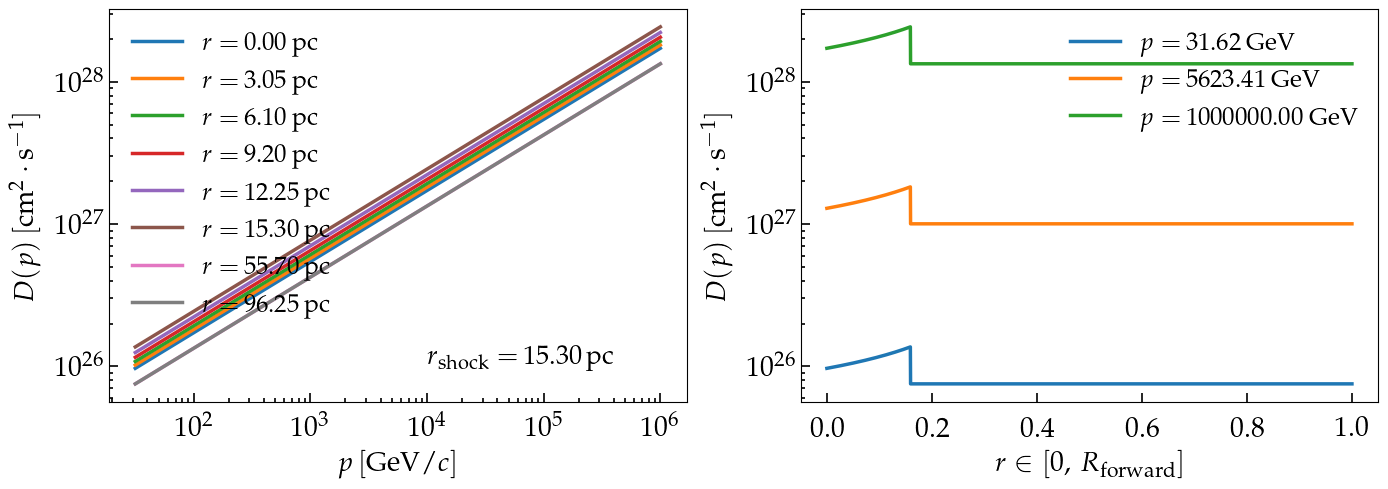

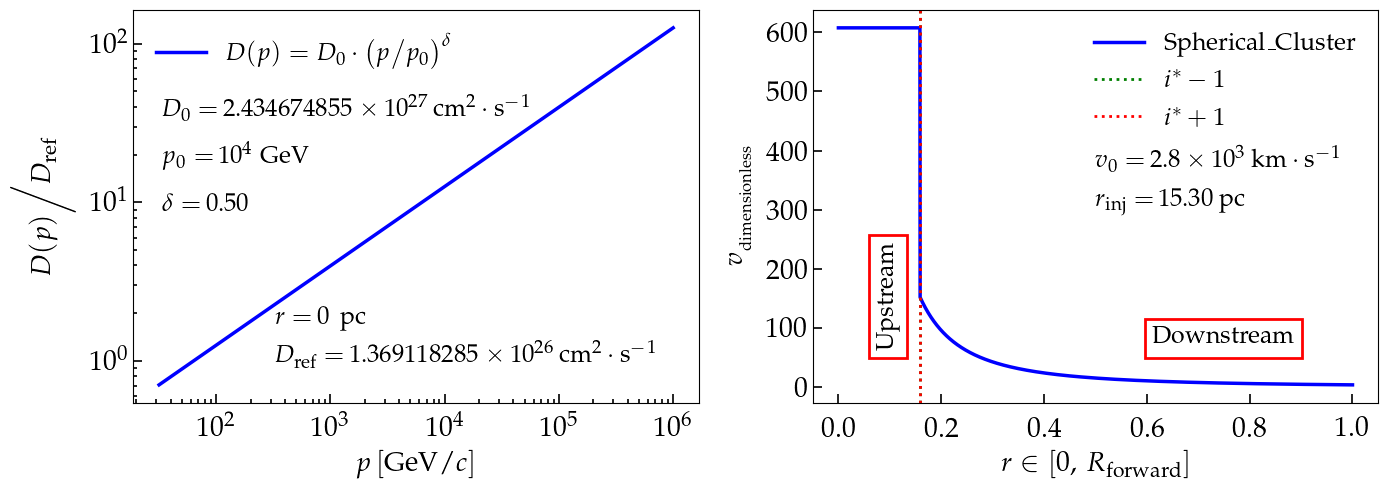

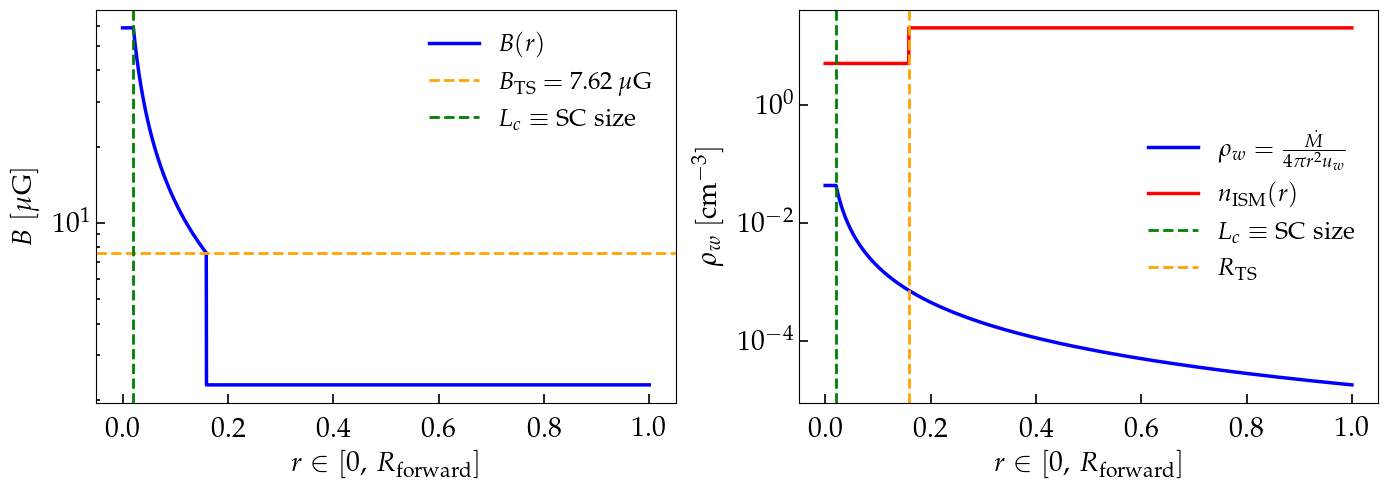

In [11]:
## Settings of the run ##


# time grid
timescale_adv = (L_ref*conv_pc_cm / v_0_cm) * conv_sec_yr/1.e6
timescale_diff = (L_ref*conv_pc_cm)**2 / (2 * np.max(D_matrix)) * conv_sec_yr/1.e6
timescale_acc = 3. / (v_0_cm - v_0_cm/compr_factor) * ( (np.min(D_matrix) / v_0_cm) + (np.min(D_matrix) / (v_0_cm/compr_factor)) ) * conv_sec_yr/1.e6
timescale_losses = min(integrals_losses_KN * conv_sec_yr/1.e+6)

minimum_tau = min(timescale_adv, timescale_diff, timescale_acc, timescale_losses)
factor_dt = 2.e1                                         # divide the minimum timescale, to fix dt
dt_tot_Myr = minimum_tau / factor_dt                     # dimensional timestep, in [Myr]
Nt = int(t_physical_yr/1.e6 / (dt_tot_Myr))
dt_tot = (dt_tot_Myr*1.e6*conv_yr_sec) / ( (L_ref*conv_pc_cm)**2 / D_ref )   # dimensionless
diff_length_dless = np.sqrt(2 * D_0/D_ref * dt_tot)
t_grid = np.arange(start=0., stop=Nt*dt_tot, step=dt_tot)
dt = dt_tot / n_op
t_true = (Nt * dt_tot_Myr)                               # true duration of the run, in [Myr]



print('Nx =', Nx, ', Nt =', Nt, ', Np =', Np)
print('')
print('** Space information **')
print('min dimensionless dx =', dx_min)
print('min physical space step =' , dx_physical_min, '[pc]')
print('max dimensionless dx =', dx_max)
print('max physical space step =' , dx_physical_max, '[pc]')
print('')
print('** Time information **')
print('minimum diffusive timescale:', timescale_diff, '[Myr]')
print('minimum advective timescale:', timescale_adv, '[Myr]')
print('minimum losses timescale:', timescale_losses, '[Myr]')
print('dimensionless dt_tot =', dt_tot)
print('physical time interval, dt_tot =', dt_tot_Myr, '[Myr]')
print('physical time of the whole run, T_tot =', t_true, '[Myr]')
print('')
print('** Momentum information **')
print(f'min momentum = {p_grid[0]} GeV, max momentum = {p_grid[-1]} GeV')
print('minimum step in the momentum grid =', dp_min, '[GeV]')
print('')
print('** Acceleration information **')
print('minimum acceleration timescale:', timescale_acc, '[Myr]')



plt.figure(figsize=(14, 5))

# diffusion coefficient subplots
plt.subplot(1, 2, 1)
plot_cosmetics_multi()


loc_diff_coeff_upstream = np.linspace(start=start_x_grid, stop=shock_location, num=5, endpoint=False)
loc_diff_coeff_downstream = np.linspace(start=shock_location, stop=stop_x_grid, num=3)
loc_diff_coeff = np.concatenate((loc_diff_coeff_upstream, loc_diff_coeff_downstream))
indx_diff_coeff = [np.argmin( abs(loc_diff_coeff[ix] - x_grid) ) for ix in range(len(loc_diff_coeff))]

for ix in range(len(loc_diff_coeff)):
    plt.loglog(p_grid, D_matrix[indx_diff_coeff[ix], :], lw=2.5, label='$r = \, $' + str("{:.2f}".format(L_ref*x_grid[indx_diff_coeff[ix]])) + '$\, \mathrm{pc}$')

plt.xlabel('$ p \, [\mathrm{GeV}/c]$',fontsize=20)
plt.ylabel('$ D(p) \, [\mathrm{cm^2} \cdot \mathrm{s^{-1}}]$',fontsize=20)
plt.text(0.55, 0.1, '$r_{\mathrm{shock}} = \,$' + str("{:.2f}".format(shock_location*L_ref)) + '$\, \mathrm{pc}$', fontsize=19, transform = plt.gca().transAxes)
plt.legend(fontsize=18, frameon=False, loc='upper left')


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

en_diff_coeff = np.logspace(start=np.log10(min(p_grid)), stop=np.log10(max(p_grid)), num=3)
indx_en_diff_coeff = [np.argmin( abs(en_diff_coeff[ip] - p_grid) ) for ip in range(len(en_diff_coeff))]


for ip in range(len(en_diff_coeff)):
    plt.plot(x_grid, D_matrix[:, indx_en_diff_coeff[ip]], lw=2.5, label='$p = \,$' + str("{:.2f}".format(p_grid[indx_en_diff_coeff[ip]])) + '$\, \mathrm{GeV}$')
    
plt.yscale('log')
plt.xlabel('$ r \in [0, \, R_{\mathrm{forward}}]$',fontsize=20)
plt.ylabel('$ D(p) \, [\mathrm{cm^2} \cdot \mathrm{s^{-1}}]$',fontsize=20)
plt.legend(fontsize=18, frameon=False, loc='best')
plt.tight_layout()
################################################################



plt.figure(figsize=(14, 5))

# diffusion coefficient subplot
plt.subplot(1, 2, 1)
plot_cosmetics_multi()


plt.loglog(p_grid, D_matrix[space_point_diff, :] / D_ref, lw=2.5, color='blue', label='$D(p) = D_0 \\cdot \\left( p \\big/ p_0 \\right)^\\delta$')
plt.xlabel('$ p \, [\mathrm{GeV}/c]$',fontsize=20)
plt.ylabel('$ D(p) \\bigg/ D_{\mathrm{ref}}$',fontsize=20)
plt.legend(fontsize=18, frameon=False)
plt.text(0.05, 0.73, '$D_0 = \,$' + str("${}$".format(f.format_data(D_0))) + '$\, \mathrm{cm^2} \cdot \mathrm{s}^{-1}$', fontsize=18, transform = plt.gca().transAxes)
plt.text(0.05, 0.61, '$p_0 = \,$' + str("${}$".format(f.format_data(p_0_diff))) + ' GeV', fontsize=18, transform = plt.gca().transAxes)
plt.text(0.05, 0.49, '$\\delta = \,$' + str("{:.2f}".format(delta_diff)), fontsize=18, transform = plt.gca().transAxes)
plt.text(0.25, 0.2, '$r = \,$' + str("{:.0f}".format(x_grid[space_point_diff] * L_ref)) + '\, pc', fontsize=18, transform = plt.gca().transAxes)
plt.text(0.25, 0.1, '$D_{\mathrm{ref}} = \,$' + str("${}$".format(f.format_data(D_ref))) + '$\, \mathrm{cm^2} \cdot \mathrm{s}^{-1}$', fontsize=18, transform = plt.gca().transAxes)
################################################################


# velocity-profile subplot
plt.subplot(1, 2, 2)
plot_cosmetics_multi()


plt.plot(x_grid, v_adv, lw=2.5, color='blue', label=label_v_profile)
plt.axvline(x=x_grid[shock_index-1], ls=':', lw=2., color='green', label='$i^* - 1$')
plt.axvline(x=x_grid[shock_index+1], ls=':', lw=2., color='red', label='$i^* + 1$')
plt.xlabel('$ r \in [0, \, R_{\mathrm{forward}}]$',fontsize=20)
plt.ylabel('$ v_{_\mathrm{dimensionless}}$',fontsize=20)
plt.legend(fontsize=18, frameon=False, loc='upper right')


if case_velocity == 'symmetric_velocity':
    plt.text(0.05, 0.35, '$v_0 = \,$' + str("${}$".format(f.format_data(v_0))) + '$\, \mathrm{km} \cdot \mathrm{s}^{-1}$', fontsize=19, transform = plt.gca().transAxes)
    plt.text(0.05, 0.25, '$\\Delta x_{v} = \,$' + str("{:.0f}".format(DeltaL_v)) + '$\, \mathrm{pc}$', fontsize=19, transform = plt.gca().transAxes)
    plt.text(0.05, 0.15, '$r_{\mathrm{inj}} = L/2$', fontsize=19, transform = plt.gca().transAxes)
elif case_velocity == 'step_function':
    plt.text(0.50, 0.6, '$v_0 = \,$' + str("${}$".format(f.format_data(v_0))) + '$\, \mathrm{km} \cdot \mathrm{s}^{-1}$', fontsize=19, transform = plt.gca().transAxes)
    plt.text(0.50, 0.5, '$r_{\mathrm{inj}} = L/2$', fontsize=19, transform = plt.gca().transAxes)
else:
    plt.text(0.50, 0.6, '$v_0 = \,$' + str("${}$".format(f.format_data(v_0))) + '$\, \mathrm{km} \cdot \mathrm{s}^{-1}$', fontsize=18, transform = plt.gca().transAxes)
    plt.text(0.50, 0.5, '$r_{\mathrm{inj}} = \,$' + str("{:.2f}".format(shock_location*L_ref)) + '$\, \mathrm{pc}$', fontsize=18, transform = plt.gca().transAxes)
    
    
plt.text(shock_location - 0.3*shock_location, 0.15, 'Upstream', fontsize=18, rotation=90, bbox=dict(lw=2, facecolor='none', edgecolor='red', pad=5.0), transform = plt.gca().transAxes)
plt.text(0.6, 0.15, 'Downstream', fontsize=18, bbox=dict(lw=2, facecolor='none', edgecolor='red', pad=5.0), transform = plt.gca().transAxes)
plt.tight_layout()
plt.savefig('VelocityProfile.pdf',format='pdf',bbox_inches='tight', dpi=200)
################################################################



# plot the magnetic field and plot the density
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()


plt.plot(x_grid, B_space, lw=2.5, color='blue', label='$B(r)$')
plt.axhline(y=B_TS, ls='--', lw=2., color='orange', label='$B_\mathrm{TS} = \;$' + str("{:.2f}".format(B_TS)) + '$\, \\mu \mathrm{G}$')
plt.axvline(x=L_c/L_ref, ls='--', lw=2., color='green', label='$L_c \equiv \mathrm{SC \; size}$')
plt.yscale('log')
plt.xlabel('$ r \in [0, \, R_{\mathrm{forward}}]$',fontsize=20)
plt.ylabel('$B \; [\mu \mathrm{G}]$',fontsize=20)
plt.legend(fontsize=18, frameon=False, loc='best')



'''plt.plot(x_grid, v_adv_derivative_Rsquare, lw=2., color='blue', label='$\\frac{d}{dr} \\left[ r^2 u_w(r) \\right]$')
plt.xlabel('$ r \in [0, \, R_{\mathrm{forward}}]$',fontsize=20)
plt.ylabel('$ \\frac{d}{dr} \\left[r^2 u_w(r) \\right] \\big\\vert_{_\mathrm{dimensionless}}$',fontsize=20)
plt.legend(fontsize=18, frameon=False, loc='best')
'''

plt.subplot(1, 2, 2)
plot_cosmetics_multi()
    

plt.plot(x_grid, wind_density_array, lw=2.5, color='blue', label='$\\rho_w = \\frac{\dot{M}}{4 \pi r^2 u_w}$')
plt.plot(x_grid, n_ISM_array, lw=2.5, color='red', label='$n_{\mathrm{ISM}}(r)$')
plt.yscale('log')
plt.axvline(x=L_c/L_ref, lw=2., ls='--', color='green', label='$L_c \equiv \mathrm{SC \; size}$')
plt.axvline(x=R_TS / L_ref, lw=2., ls='--', color='orange', label='$R_{\mathrm{TS}}$')
plt.xlabel('$ r \in [0, \, R_{\mathrm{forward}}]$',fontsize=20)
plt.ylabel('$\\rho_w \; [\mathrm{cm^{-3}}]$',fontsize=20)
plt.legend(fontsize=18, frameon=False, loc='best')
plt.tight_layout()
############################################

In [12]:
# Injection data #

p_injection = p_grid[0]*5      # p_inj at the shock, in [GeV]
indx_p_inj = np.argmin( abs(p_injection - p_grid) )
indx_x_inj = shock_index
x_injection = x_grid[indx_x_inj]

print('injection momentum =', p_injection, '[GeV]')
print('injection at p index:', indx_p_inj)

injection momentum = 158.11388300841895 [GeV]
injection at p index: 636


The shock is at index: 386

shape of the source matrix: (1180, 4097)

Directory /Users/ottaviofornieri/PHYSICS_projects/GitProjects/StellarClusters/Stored_solutions/Radau_SphericalShock_T=3.0Myr_nISM=20.0_Np=4096_deltaDiff=0.5/ created



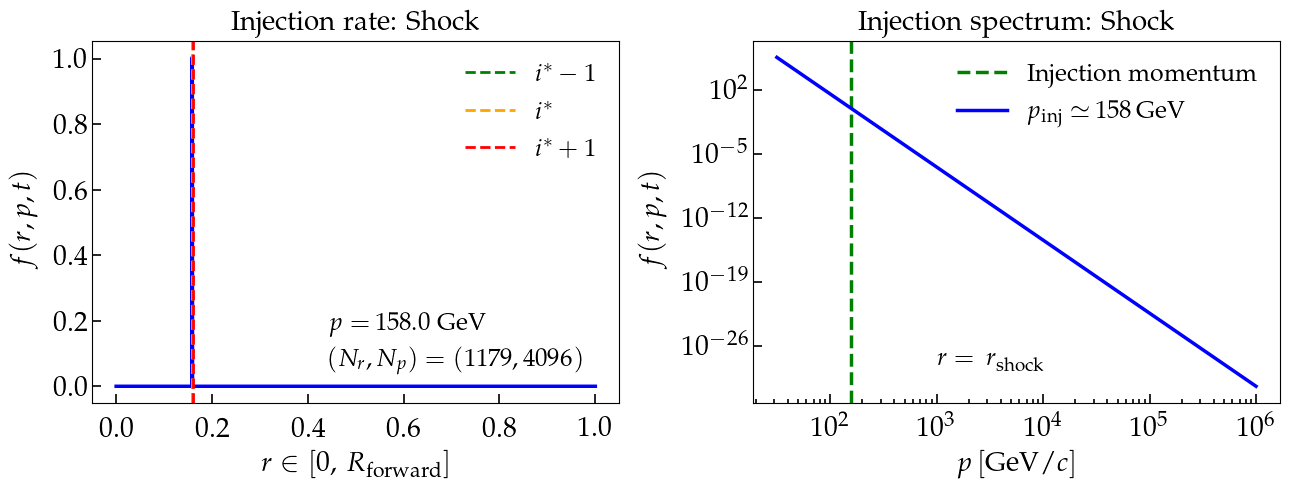

In [13]:
### Block to study the source function ###


# Choose a source function, as injection rate #
case = 'Shock'                 # other options include: gaussian_burst, constant, StepFunction, ...
p_0 = min(p_grid)
Source_slope = 8.
print('The shock is at index:', indx_x_inj)
print('')


# normalization of the injection function (norm_inj)
norm_inj = 1.
def source_func(x_space, p_momentum):
    
    if case == 'Shock':
        temp_p = (p_momentum[:] / p_injection)**(-Source_slope)
        temp_x = [norm_inj if ix == indx_x_inj or ix == indx_x_inj-1 else 0. for ix in range(len(x_grid))]
        
    source_function_array = np.asarray([[temp_x[ix] * temp_p[ip] for ip in range(len(p_grid))] for ix in range(len(x_grid))])
    return source_function_array


source_matrix = source_func(x_grid, p_grid)
source_matrix[source_matrix < 1.e-100] = 0
print(f'shape of the source matrix: {source_matrix.shape}')
print('')


# Plot the source function
plt.figure(figsize=(13,5))


plt.subplot(1, 2, 1)
plot_cosmetics_multi()

plt.plot(x_grid, source_matrix[:, indx_p_inj], lw=2.5, color='blue')
plt.axvline(x=x_grid[indx_x_inj-1], ls='--', lw=2., color='green', label='$i^* - 1$')
plt.axvline(x=x_grid[indx_x_inj], ls='--', lw=2., color='orange', label='$i^*$')
plt.axvline(x=x_grid[indx_x_inj+1], ls='--', lw=2., color='red', label='$i^* + 1$')
plt.title('Injection rate: ' + str(case), fontsize = 20, pad=8)
plt.xlabel('$r \in [0, \, R_{\mathrm{forward}}]$', fontsize=20)
plt.ylabel('$f(r, p, t)$', fontsize=20)
plt.text(0.45, 0.2, '$p = \,$' + str("{:.1f}".format(p_grid[indx_p_inj])) + ' GeV', fontsize=18, transform = plt.gca().transAxes)
plt.text(0.45, 0.1, '$(N_r, N_p) = ($' + str(Nx) + ',\,' + str(Np) + '$)$', fontsize=18, transform = plt.gca().transAxes)
plt.legend(frameon=False, fontsize=18)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

plt.axvline(x=p_grid[indx_p_inj], ls='--', lw=2.5, color='green', label='Injection momentum')
plt.loglog(p_grid, source_matrix[indx_x_inj, :], lw=2.5, color='blue', label='$p_{\mathrm{inj}} \\simeq \, $' + str(round(p_grid[indx_p_inj])) + '$\, \mathrm{GeV}$')
plt.title('Injection spectrum: ' + str(case), fontsize=20, pad=8)
plt.xlabel('$p \, [\mathrm{GeV}/c]$', fontsize=20)
plt.ylabel('$f(r, p, t)$', fontsize=20)
plt.legend(frameon=False, fontsize=18)
plt.text(0.35, 0.1, '$r = \, r_{\mathrm{shock}}$', fontsize=18, transform = plt.gca().transAxes)
plt.tight_layout()


path_PDE = '/Users/ottaviofornieri/PHYSICS_projects/GitProjects/StellarClusters/'
solutions_folder_name = 'Radau_SphericalShock_T=' + str("{:.1f}".format(t_true)) + 'Myr_nISM=' + str(n_ISM) + '_Np=' + str(Np) + '_deltaDiff=' + str(delta_diff)
dirName = path_PDE + 'Stored_solutions/' + str(solutions_folder_name) + '/'

try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory", dirName, "created")
    print("")
except FileExistsError:
    print("Directory", dirName, "already exists")
    print("")
    

plt.savefig(dirName + 'SourceFunction.pdf',format='pdf',bbox_inches='tight', dpi=200)

Nx = 1180 , Np = 4097

original source matrix: [390625.    382799.157 375130.097 367614.681 360249.83  353032.528
 345959.818 339028.804 332236.647]

adjusted source matrix: [394617.916 386712.078 378964.627 371372.389 363932.256 356641.179
 349496.173 342494.311 335632.725]

max of the source function:  789235.8329017395



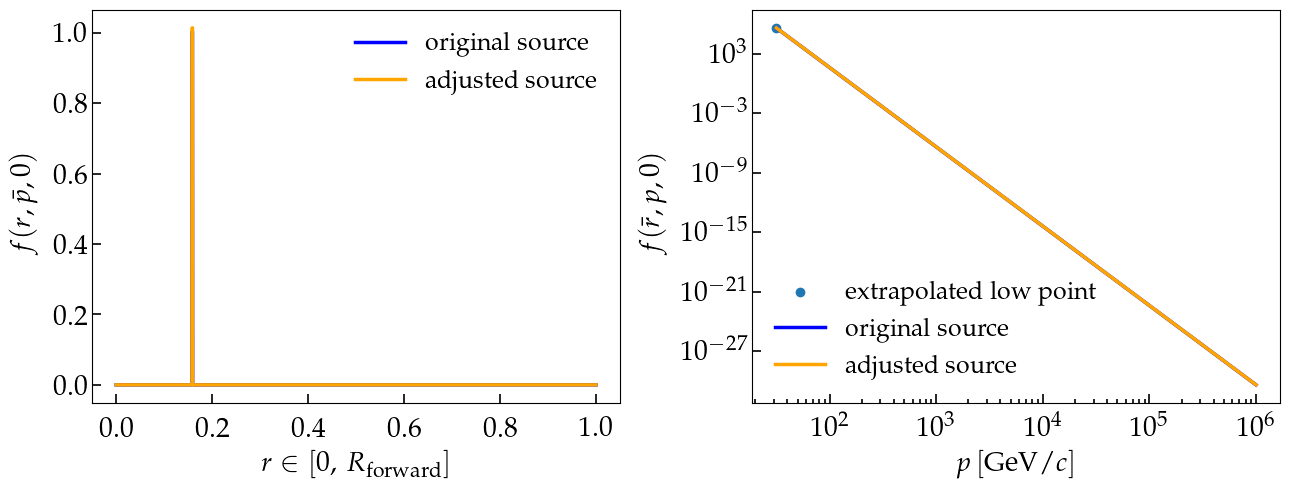

In [14]:
## Block to adjust the source function: medium point + multiplication by time-step ##


print('Nx =', len(x_grid), ', Np =', len(p_grid))
print('')
print('original source matrix:', source_matrix[indx_x_inj, :9])
print('')


Source_lower1 = [max(source_matrix[ix,:]) * (p_lower1 / p_0)**(-Source_slope) for ix in range(len(x_grid))]

source_matrix_adjusted = np.zeros( (len(x_grid), len(p_grid)) )
for ix in range(len(x_grid)):
    source_matrix_adjusted[ix,:] = [(source_matrix[ix,ip] + Source_lower1[ix]) / 2. if ip == 0 else (source_matrix[ix,ip] + source_matrix[ix,ip-1]) / 2. for ip in range(len(p_grid))]
    
    
print('adjusted source matrix:', source_matrix_adjusted[indx_x_inj, :9])
print('')

print('max of the source function: ', np.max(source_matrix_adjusted)*2)
print('')


plt.figure(figsize=(13,5))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

plt.plot(x_grid, source_matrix[:,indx_p_inj], lw=2.5, color='blue', label='original source')
plt.plot(x_grid, source_matrix_adjusted[:,indx_p_inj], lw=2.5, color='orange', label='adjusted source')
plt.xlabel('$r \in [0, \, R_{\mathrm{forward}}]$', fontsize=20)
plt.ylabel('$f(r, \\bar{p}, 0)$', fontsize=20)
plt.legend(frameon=False, fontsize=18, loc='best')


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

plt.scatter(p_lower1, Source_lower1[indx_x_inj], label='extrapolated low point')
plt.loglog(p_grid[:], source_matrix[indx_x_inj, :], lw=2.5, color='blue', label='original source')
plt.loglog(p_grid[:], source_matrix_adjusted[indx_x_inj, :], lw=2.5, color='orange', label='adjusted source')
plt.xlabel('$p \, [\mathrm{GeV}/c]$', fontsize=20)
plt.ylabel('$f(\\bar{r}, p, 0)$', fontsize=20)
plt.legend(frameon=False, fontsize=18, loc='best')
plt.tight_layout()

In [15]:
## Block to define the mapping ##


print(f'len(x_grid) = {len(x_grid)}, len(p_grid) = {len(p_grid)}')
print(f'last index = {len(x_grid)*len(p_grid) - 1}')


def indx_mapping(ix_, ip_):    
    return ix_ + len(x_grid) * ip_ 



source_mapped = np.zeros(len(x_grid)*len(p_grid) + 1 )
for ix in range(0, len(x_grid)):
    for ip in range(0, len(p_grid)):
        source_mapped[indx_mapping(ix,ip)] = source_matrix_adjusted[ix,ip]
        
        
D_mapped = np.zeros(len(x_grid)*len(p_grid) )
for ix in range(0, len(x_grid)):
    for ip in range(0, len(p_grid)):
        D_mapped[indx_mapping(ix,ip)] = D_matrix_dless[ix,ip]



        

def rev_dict(k):
    i = int(k % len(x_grid))
    j = int((k - i) / len(x_grid))
    return i, j
        

#print('')
#for ik in range(0, len(x_grid)*len(p_grid)):
#    print(f'k = {ik}   ->   {rev_dict(ik)}')

len(x_grid) = 1180, len(p_grid) = 4097
last index = 4834459


In [16]:
case_transport = 'DSA_spherical'
particle_type = 'protons_ppLoss'


if case_transport == 'DSA_spherical':
    
    if particle_type == 'protons':

        # without losses
        def fun_rhs(t, f_):

            dfdt = np.zeros( len(x_grid)*len(p_grid) )
            for ik in range(1, len(x_grid)*len(p_grid) - 1 ):

                ix, ip = rev_dict(ik)
                f_[indx_mapping(0,ip)] = (D_matrix_dless[0,ip] / x_grid[1]) / (D_matrix_dless[0,ip] / x_grid[1] + v_adv[0]) * f_[indx_mapping(1,ip)]

                if ix != 0 and ix != len(x_grid)-1 and ip != 0 and ip != len(p_grid)-1 :


                    dfdt[ik] = 1. / ( 2. * x_grid[ix]**2 * (x_grid[ix+1] - x_grid[ix-1]) ) \
                           * ( ( x_grid[ix]**2 + x_grid[ix+1]**2 ) * (D_matrix_dless[ix,ip] + D_matrix_dless[ix+1,ip]) * (f_[indx_mapping(ix+1,ip)] - f_[indx_mapping(ix,ip)])/(x_grid[ix+1] - x_grid[ix]) \
                           - ( x_grid[ix]**2 + x_grid[ix-1]**2 ) * (D_matrix_dless[ix,ip] + D_matrix_dless[ix-1,ip]) * (f_[indx_mapping(ix,ip)] - f_[indx_mapping(ix-1,ip)])/(x_grid[ix] - x_grid[ix-1]) ) \
                           - v_adv[ix] * (f_[indx_mapping(ix,ip)] - f_[indx_mapping(ix-1,ip)]) / (x_grid[ix] - x_grid[ix-1]) \
                           + (2. * v_adv[ix] / x_grid[ix]) * p_grid[ip] / 3. * ( f_[indx_mapping(ix,ip+1)] - f_[indx_mapping(ix,ip)] ) / (p_grid[ip+1] - p_grid[ip]) \
                           + p_grid[ip] / 3. * v_adv_derivative[ix] * ( f_[indx_mapping(ix,ip)] - f_[indx_mapping(ix,ip-1)] ) / (p_grid[ip] - p_grid[ip-1]) \
                           + source_matrix_adjusted[ix,ip]

            return dfdt
        
        
    elif particle_type == 'protons_ppLoss':

        # with pion-production losses
        def fun_rhs(t, f_):

            dfdt = np.zeros( len(x_grid)*len(p_grid) )
            for ik in range(1, len(x_grid)*len(p_grid) - 1 ):

                ix, ip = rev_dict(ik)
                f_[indx_mapping(0,ip)] = (D_matrix_dless[0,ip] / x_grid[1]) / (D_matrix_dless[0,ip] / x_grid[1] + v_adv[0]) * f_[indx_mapping(1,ip)]

                if ix != 0 and ix != len(x_grid)-1 and ip != 0 and ip != len(p_grid)-1 :


                    dfdt[ik] = 1. / ( 2. * x_grid[ix]**2 * (x_grid[ix+1] - x_grid[ix-1]) ) \
                           * ( ( x_grid[ix]**2 + x_grid[ix+1]**2 ) * (D_matrix_dless[ix,ip] + D_matrix_dless[ix+1,ip]) * (f_[indx_mapping(ix+1,ip)] - f_[indx_mapping(ix,ip)])/(x_grid[ix+1] - x_grid[ix]) \
                           - ( x_grid[ix]**2 + x_grid[ix-1]**2 ) * (D_matrix_dless[ix,ip] + D_matrix_dless[ix-1,ip]) * (f_[indx_mapping(ix,ip)] - f_[indx_mapping(ix-1,ip)])/(x_grid[ix] - x_grid[ix-1]) ) \
                           - v_adv[ix] * (f_[indx_mapping(ix,ip)] - f_[indx_mapping(ix-1,ip)]) / (x_grid[ix] - x_grid[ix-1]) \
                           + (2. * v_adv[ix] / x_grid[ix]) * p_grid[ip] / 3. * ( f_[indx_mapping(ix,ip+1)] - f_[indx_mapping(ix,ip)] ) / (p_grid[ip+1] - p_grid[ip]) \
                           + p_grid[ip] / 3. * v_adv_derivative[ix] * ( f_[indx_mapping(ix,ip)] - f_[indx_mapping(ix,ip-1)] ) / (p_grid[ip] - p_grid[ip-1]) \
                           - 1. / p_grid[ip]**2 * (loss_rate_pp_collision_matrix[ix, ip+1] * p_grid[ip+1]**2 * f_[indx_mapping(ix,ip+1)] - loss_rate_pp_collision_matrix[ix, ip] * p_grid[ip]**2 * f_[indx_mapping(ix,ip)]) / ( pdot_ref * (p_grid[ip+1] - p_grid[ip]) ) \
                           + source_matrix_adjusted[ix,ip]

            return dfdt
        
        
    elif particle_type == 'leptons':

        # with IC-Synchrotron losses
        def fun_rhs(t, f_):

            dfdt = np.zeros( len(x_grid)*len(p_grid) )
            for ik in range(1, len(x_grid)*len(p_grid) - 1 ):

                ix, ip = rev_dict(ik)
                f_[indx_mapping(0,ip)] = (D_matrix_dless[0,ip] / x_grid[1]) / (D_matrix_dless[0,ip] / x_grid[1] + v_adv[0]) * f_[indx_mapping(1,ip)]

                if ix != 0 and ix != len(x_grid)-1 and ip != 0 and ip != len(p_grid)-1 :


                    dfdt[ik] = 1. / ( 2. * x_grid[ix]**2 * (x_grid[ix+1] - x_grid[ix-1]) ) \
                           * ( ( x_grid[ix]**2 + x_grid[ix+1]**2 ) * (D_matrix_dless[ix,ip] + D_matrix_dless[ix+1,ip]) * (f_[indx_mapping(ix+1,ip)] - f_[indx_mapping(ix,ip)])/(x_grid[ix+1] - x_grid[ix]) \
                           - ( x_grid[ix]**2 + x_grid[ix-1]**2 ) * (D_matrix_dless[ix,ip] + D_matrix_dless[ix-1,ip]) * (f_[indx_mapping(ix,ip)] - f_[indx_mapping(ix-1,ip)])/(x_grid[ix] - x_grid[ix-1]) ) \
                           - v_adv[ix] * (f_[indx_mapping(ix,ip)] - f_[indx_mapping(ix-1,ip)]) / (x_grid[ix] - x_grid[ix-1]) \
                           + (2. * v_adv[ix] / x_grid[ix]) * p_grid[ip] / 3. * ( f_[indx_mapping(ix,ip+1)] - f_[indx_mapping(ix,ip)] ) / (p_grid[ip+1] - p_grid[ip]) \
                           + p_grid[ip] / 3. * v_adv_derivative[ix] * ( f_[indx_mapping(ix,ip)] - f_[indx_mapping(ix,ip-1)] ) / (p_grid[ip] - p_grid[ip-1]) \
                           - 1. / p_grid[ip]**2 * (loss_rate_KN_matrix[ix, ip+1] * p_grid[ip+1]**2 * f_[indx_mapping(ix,ip+1)] - loss_rate_KN_matrix[ix, ip] * p_grid[ip]**2 * f_[indx_mapping(ix,ip)]) / ( pdot_ref * (p_grid[ip+1] - p_grid[ip]) ) \
                           + source_matrix_adjusted[ix,ip]

            return dfdt

In [17]:
from scipy.sparse import dia_array

Nk = len(x_grid) * len(p_grid)
data = [np.ones(Nk)]*5
jac_sparsity = dia_array((data, [-len(x_grid), -1, 0, 1, len(x_grid)]), shape=(Nk, Nk), dtype=np.float64)

In [18]:
## Modify the solve_ivp method to show a progress bar ##

from scipy.integrate._ivp.base import OdeSolver
#from tqdm import tqdm
from tqdm.notebook import tqdm


# save the old methods
old_init = OdeSolver.__init__
old_step = OdeSolver.step

# define our own methods
def new_init(self, fun, t0, y0, t_bound, vectorized, support_complex=False):

    # define the progress bar
    self.pbar = tqdm(total=t_bound - t0, unit='ut', initial=t0, ascii=True, desc='IVP')
    self.last_t = t0
    
    # call the old method - we still want to do the old things too!
    old_init(self, fun, t0, y0, t_bound, vectorized, support_complex)


def new_step(self):
    # call the old method
    old_step(self)
    
    # update the bar
    tst = self.t - self.last_t
    self.pbar.update(tst)
    self.last_t = self.t

    # close the bar if the end is reached
    if self.t >= self.t_bound:
        self.pbar.close()


# overwrite the old methods with our customized ones
OdeSolver.__init__ = new_init
OdeSolver.step = new_step


In [19]:
## Block with the calculation ##

last_timestep_dless = Nt*dt_tot
t_eval_array = np.logspace(start=np.log10(dt_tot), stop=np.log10(last_timestep_dless-0.001*last_timestep_dless), num=7)
start = time.process_time()


output = scipy.integrate.solve_ivp(fun_rhs, [0., last_timestep_dless], np.zeros( len(x_grid)*len(p_grid), dtype=np.float64), method='BDF', t_eval=t_eval_array, jac_sparsity=jac_sparsity, dense_output=False, events=None, vectorized=False, args=None, atol=1.e-2, rtol=1.e-2)


runtime = time.process_time() - start
print ('It took', runtime, "seconds")

IVP:   0%|          | 0.0/0.14683680804053253 [00:00<?, ?ut/s]

It took 10471.636674 seconds


In [20]:
import psutil
import sys
from sys import getsizeof
import humanize


print(f'size of my array: {sys.getsizeof(np.arange(Nk*5)) / 2**30} [GiB] = {sys.getsizeof(np.arange(Nk*5)) / 2**30 * 1.07374} [GB]')
print('')

print('MEMORY USAGE')
print('*********')
print('')


print(f'total memory (including SWAP) = {humanize.naturalsize(psutil.virtual_memory()[0])}')
print(f'available memory for processes = {humanize.naturalsize(psutil.virtual_memory()[1])}')
print(f'RAM memory % used: = {psutil.virtual_memory()[2]} %')
print(f'RAM Used: {humanize.naturalsize(psutil.virtual_memory()[3])}')
print(f'memory not used and is readily available: {humanize.naturalsize(psutil.virtual_memory()[4])}')
print(f'active = {humanize.naturalsize(psutil.virtual_memory()[5])}')
print(f'inactive = {humanize.naturalsize(psutil.virtual_memory()[6])}')
print(f'wired = {humanize.naturalsize(psutil.virtual_memory()[7])}')

size of my array: 0.1800977736711502 [GiB] = 0.1933781835016608 [GB]

MEMORY USAGE
*********

total memory (including SWAP) = 34.4 GB
available memory for processes = 17.9 GB
RAM memory % used: = 48.0 %
RAM Used: 11.7 GB
memory not used and is readily available: 8.2 GB
active = 9.7 GB
inactive = 9.6 GB
wired = 2.0 GB


len(x_grid) = 1180, len(p_grid) = 4097, case = DSA_spherical

last dimensionless instant: 0.14683680804053253
length of the time array: 7

time steps: [5.277e-07 4.263e-06 3.444e-05 2.782e-04 2.248e-03 1.816e-02 1.467e-01]


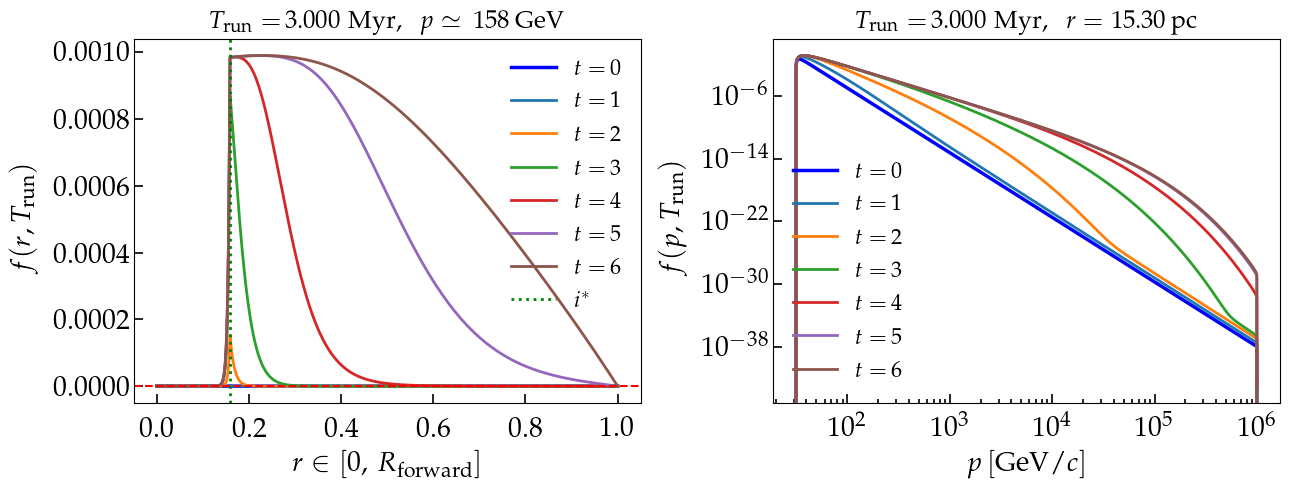

In [21]:
print(f'len(x_grid) = {len(x_grid)}, len(p_grid) = {len(p_grid)}, case = {case_transport}')
print('')
print(f'last dimensionless instant: {Nt*dt_tot}')
print(f'length of the time array: {len(output.t)}')
print('')
print(f'time steps: {output.t}')



sol = np.zeros( (len(output.t), len(x_grid), len(p_grid)) )
for it in range(0, len(output.t)):
    for ip in range(0, len(p_grid)):

        momentum_indx_start = ip * len(x_grid)
        momentum_indx_stop = (ip+1) * len(x_grid) - 1
        
        sol[it, :, ip] = output.y[momentum_indx_start:momentum_indx_stop+1, it]
        sol[it, 0, ip] = (D_mapped[indx_mapping(0,ip)] / x_grid[1]) / (D_mapped[indx_mapping(0,ip)] / x_grid[1] + v_adv[0]) * sol[it, 1, ip]

    
plt.figure(figsize=(13,5))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()



shown_momentum = indx_p_inj
for it in range(0, len(output.t)):
    if it == 0:
        plt.plot(x_grid, sol[it, :, shown_momentum], ls='-', lw=2.5, color='blue', label='$t = \,$' + str(it))
    else:
        plt.plot(x_grid, sol[it, :, shown_momentum], ls='-', lw=2., label='$t = \,$' + str(it))

            
plt.title('$T_{\mathrm{run}} = \,$' + str("{:.3f}".format(t_true)) + '$\; \mathrm{Myr}, \; \; p \simeq \,' + str(round(p_grid[shown_momentum])) + '\, \mathrm{GeV}$', fontsize=18, pad=8)
plt.axvline(x=x_grid[indx_x_inj], ls=':', lw=2., color='green', label='$i^*$')
plt.axhline(y=0., ls='--', lw=1.5, color='red')
plt.xlabel('$r \in [0, \, R_{\mathrm{forward}}]$', fontsize=20)
plt.ylabel('$f(r, T_{\mathrm{run}})$', fontsize=20)
plt.legend(frameon=False, fontsize=16, loc='best')



plt.subplot(1, 2, 2)
plot_cosmetics_multi()


indx_x_spectrum = indx_x_inj
indx_10TeV = np.argmin( abs(p_grid - 1.e4) )


for it in range(0, len(output.t)):
    if it == 0:
        plt.loglog(p_grid[:], sol[it, indx_x_inj, :], ls='-', lw=2.5, color='blue', label='$t = \,$' + str(it))
    else:
        plt.loglog(p_grid[:], sol[it, indx_x_inj, :], ls='-', lw=2., label='$t = \,$' + str(it))



plt.title('$T_{\mathrm{run}} = \,$' + str("{:.3f}".format(t_true)) + '$\; \mathrm{Myr}, \;\; r = \; $' + str("{:.2f}".format(shock_location*L_ref)) + '$\, \mathrm{pc}$', fontsize=18, pad=8)
if particle_type == 'leptons':
    plt.axvline(x=p_grid[indx_intersec_LossAcc], ls='--', lw=1.5, color='Orange', label='$\\tau_{\mathrm{loss}} \leq \\tau_{\mathrm{acc}}$')
plt.xlabel('$p \, [\mathrm{GeV}/c]$', fontsize=20)
plt.ylabel('$f(p,T_{\mathrm{run}})$', fontsize=20)
plt.legend(frameon=False, fontsize=16, loc='best')
plt.tight_layout()

Fit`s parameters (a, b): [0.597 3.982]

len(x_grid) = 1180, len(p_grid) = 4097, case = DSA_spherical
Nk = 4834460
RAM Used: 4.1 GB

last dimensionless instant: 0.14683680804053253
length of the time array: 7

time steps: [5.277e-07 4.263e-06 3.444e-05 2.782e-04 2.248e-03 1.816e-02 1.467e-01]



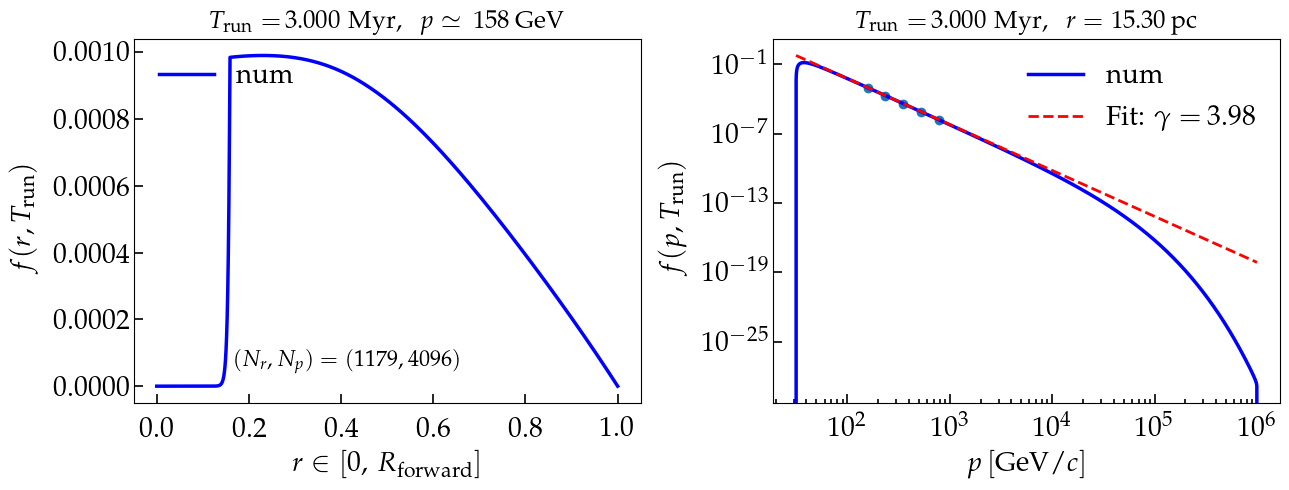

In [22]:
## Block to plot the last snapshot ##


# Fit the propagated function #
def fit_func(p_fit, a, b):
    return (norm_inj*a) * (p_fit / min(p_grid))**(-b)

p_fit_array = np.logspace(start=np.log10(p_grid[indx_p_inj]*1.), stop=np.log10(p_grid[indx_p_inj]*5.), num=5)
p_fit_array_indx = [np.argmin( abs(p_fit_array[i] - p_grid) ) for i in range(len(p_fit_array))]


popt, pcov = optimize.curve_fit(fit_func, p_grid[p_fit_array_indx], sol[-1, indx_x_inj, p_fit_array_indx], maxfev=1000)
propagated_slope_fit = popt[1]
print('Fit`s parameters (a, b):', popt)
print('')
###############################



plt.figure(figsize=(13,5))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()


plt.plot(x_grid, sol[-1, :, shown_momentum], ls='-', lw=2.5, color='blue', label='num')
plt.title('$T_{\mathrm{run}} = \,$' + str("{:.3f}".format(t_true)) + '$\; \mathrm{Myr}, \; \; p \simeq \,' + str(round(p_grid[shown_momentum])) + '\, \mathrm{GeV}$', fontsize=18, pad=8)
plt.xlabel('$r \in [0, \, R_{\mathrm{forward}}]$', fontsize=20)
plt.ylabel('$f(r,T_{\mathrm{run}})$', fontsize=20)
plt.legend(frameon=False, fontsize=20, loc='upper left')
plt.text(0.2, 0.1, '$(N_r, N_p) = ($' + str(Nx) + ',\,' + str(Np) + '$)$', fontsize=16, transform = plt.gca().transAxes)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()


indx_x_spectrum = indx_x_inj
indx_10TeV = np.argmin( abs(p_grid - 1.e4) )


plt.loglog(p_grid[:], sol[-1, indx_x_inj, :], ls='-', lw=2.5, color='blue', label='num')
plt.loglog(p_grid, fit_func(p_grid, popt[0], popt[1]), lw=2., ls='--', color='red', label='Fit: $\\gamma = \,$' + str("{:.2f}".format(popt[1])))
plt.scatter(p_fit_array, sol[-1, indx_x_inj, p_fit_array_indx])
plt.title('$T_{\mathrm{run}} = \,$' + str("{:.3f}".format(t_true)) + '$\; \mathrm{Myr}, \;\; r = \;$' + str("{:.2f}".format(shock_location*L_ref)) + '$\, \mathrm{pc}$', fontsize=18, pad=8)
if particle_type == 'leptons':
    plt.axvline(x=p_grid[indx_intersec_LossAcc], ls='--', lw=1.5, color='Orange', label='$\\tau_{\mathrm{loss}} \leq \\tau_{\mathrm{acc}}$')
plt.xlabel('$p \, [\mathrm{GeV}/c]$', fontsize=20)
plt.ylabel('$f(p,T_{\mathrm{run}})$', fontsize=20)
plt.legend(frameon=False, fontsize=20, loc='best')
plt.tight_layout()


print(f'len(x_grid) = {len(x_grid)}, len(p_grid) = {len(p_grid)}, case = {case_transport}')
print(f'Nk = {len(x_grid)*len(p_grid)}')
print(f'RAM Used: {humanize.naturalsize(psutil.virtual_memory()[3])}')
print('')
print(f'last dimensionless instant: {Nt*dt_tot}')
print(f'length of the time array: {len(output.t)}')
print('')
print(f'time steps: {output.t}')
print('')

plt.savefig(dirName + 'LastSnapshot_deltadiff=' + str(delta_diff) + '.pdf',format='pdf',bbox_inches='tight', dpi=200)

## <center> Normalization of the solution
    
$$
\begin{aligned}
P_{\mathrm{CR}} &\equiv \frac{1}{3} \int d^3 \mathbf{p} \cdot \mathbf{p} \, v_{\mathrm{CR}} \cdot f_{\mathrm{sh}}(\mathbf{p}) \overset{!}{=} \xi_{\mathrm{CR}} \cdot \rho_{w, \mathrm{up}} u_{w, \mathrm{up}}^2 \\
&= \frac{4 \pi c}{3} \int^{p_{\mathrm{max}}}_{p_{\mathrm{min}}} p^3 dp \, A \cdot g\left( \frac{p}{p_0} \right) = A \, \frac{4 \pi c}{3} p_0^4 \cdot \int^{\frac{p_{\mathrm{max}}}{p_0}}_{\frac{p_{\mathrm{min}}}{p_0}} dz \cdot z^{3} g(z) \\
&\underset{c\,=\,1}{\Rightarrow} \; A \, \frac{4 \pi}{3} p_0^4 \cdot \int^{\frac{p_{\mathrm{max}}}{p_0}}_{\frac{p_{\mathrm{min}}}{p_0}} dz \cdot z^{3} g(z) \overset{!}{=} \xi_{\mathrm{CR}} \cdot \rho_{w, \mathrm{up}} u_{w, \mathrm{up}}^2
\end{aligned}
$$

ram pressure of the wind: 5.912007508962501e-08 [GeV cm^(-3)]
minimum momentum considered in the run: 31.622776601683793 [GeV]
dimensionless integral of the CR pressure = 5.489205992933738
normalization of the CR distribution = 7.713617396333235e-20 [GeV^(-3) cm^(-3)]


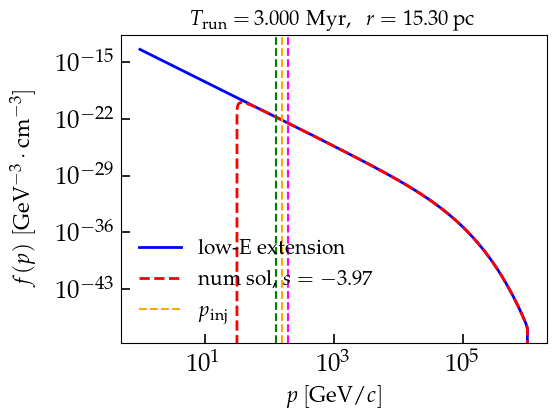

In [82]:
## Block to extend the numerical solution to low energies ##

# points that I need to compute the slope, 2% of the total number of p-grid points, above and below p_inj
points_slope = round( 2. * Np / 100 )
factor_grid = [p_grid[i] / p_grid[i-1] for i in range(1, len(p_grid))]

# number of low-E points, according to the log factor 'factor grid' computed above
Np_lowE = round(np.emath.logn( factor_grid[0], (p_grid[indx_p_inj] / 1.) ))
p_lowE = np.logspace(start=0., stop=np.log10(p_grid[indx_p_inj]), num=Np_lowE)
p_array_integral_tot = np.concatenate( (p_lowE, p_grid[indx_p_inj:]) )



# Fit the propagated function #
def fit_locations(p_fit, a, b):
    return a * (p_fit / p_grid[0])**(-b)

p_fit_loc = np.logspace(start=np.log10(p_grid[indx_p_inj-points_slope]), stop=np.log10(p_grid[indx_p_inj+points_slope]), num=4)
p_fit_loc_indx = [np.argmin( abs(p_fit_loc[i] - p_grid) ) for i in range(len(p_fit_loc))]
###############################


slope_loc = np.zeros( len(x_grid) )
for ix in range(len(x_grid)):
    slope_loc_temp, slope_cov = optimize.curve_fit(fit_locations, p_grid[p_fit_loc_indx], sol[-1, ix, p_fit_loc_indx], maxfev=1000)
    slope_loc[ix] = slope_loc_temp[1]

    
    
CR_spectrum = np.zeros( (len(x_grid), len(p_array_integral_tot)) )
for ix in range(len(x_grid)):
    if ix <= shock_index:
        CR_spectrum[ix, :] = np.concatenate( (sol[-1, ix, indx_p_inj] * ( p_lowE/p_grid[indx_p_inj] )**( - slope_loc[ix] ), sol[-1, ix, indx_p_inj:] ) )
    else:
        CR_spectrum[ix, :] = np.concatenate( (sol[-1, ix, indx_p_inj] * ( p_lowE/p_grid[indx_p_inj] )**( - slope_loc[shock_index] ), sol[-1, ix, indx_p_inj:] ) )
    

CR_spectrum_shock = CR_spectrum[indx_x_inj, :]
integral_CR_pressure = np.trapz( ( p_array_integral_tot/p_grid[0] )**3. * CR_spectrum_shock, p_array_integral_tot/p_grid[0] )

    
    
# factor A, to normalize the CR distribution function
xi_CR = 0.00003
CR_norm = 3 * xi_CR * ram_pressure_TS_GeV / (4 * np.pi * p_grid[0]**4 * integral_CR_pressure)


plt.figure(figsize=(5.5, 4.))
plot_cosmetics_single()


plt.title('$T_{\mathrm{run}} = \,$' + str("{:.3f}".format(t_true)) + '$\; \mathrm{Myr}, \;\; r = \;$' + str("{:.2f}".format(shock_location*L_ref)) + '$\, \mathrm{pc}$', fontsize=15, pad=8)
plt.loglog(p_array_integral_tot, CR_norm*CR_spectrum_shock, lw=2., color='blue', label='low-E extension')
plt.loglog(p_grid, CR_norm*sol[-1, indx_x_inj, :], ls='--', lw=2., color='red', label='num sol, $s=-$' + str("{:.2f}".format( slope_loc[indx_x_inj] )))
plt.axvline(x=p_grid[indx_p_inj], ls='--', color='orange', label='$p_{\mathrm{inj}}$')
plt.axvline(x=p_grid[indx_p_inj+points_slope], ls='--', color='magenta')
plt.axvline(x=p_grid[indx_p_inj-points_slope], ls='--', color='green')
plt.xlabel('$p \, [\mathrm{GeV}/c]$', fontsize=16)
plt.ylabel('$f(p) \; [\mathrm{GeV^{-3}} \cdot \mathrm{cm^{-3}}]$', fontsize=16)
plt.legend(fontsize=15, frameon=False, loc='lower left')


print(f'ram pressure of the wind: {ram_pressure_TS_GeV} [GeV cm^(-3)]')
print(f'minimum momentum considered in the run: {p_grid[0]} [GeV]')
print(f'dimensionless integral of the CR pressure = {integral_CR_pressure}')
print(f'normalization of the CR distribution = {CR_norm} [GeV^(-3) cm^(-3)]')

len(x_grid) = 1180, len(p_grid) = 4097, case = DSA_spherical
Nk = 4834460
RAM Used: 17.0 GB

last dimensionless instant: 0.14683680804053253
length of the time array: 7

time steps: [5.277e-07 4.263e-06 3.444e-05 2.782e-04 2.248e-03 1.816e-02 1.467e-01]

It took 10471.636674 seconds


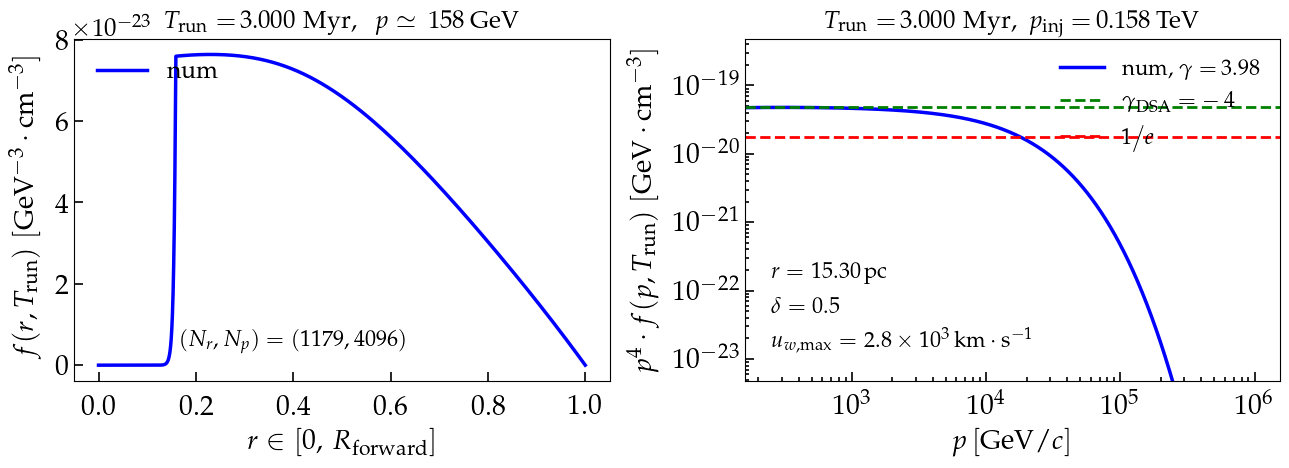

In [83]:
## Block to plot the last snapshot, solution multiplied by p^4 ##


plt.figure(figsize=(13,5))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()


plt.plot(x_grid, CR_norm*sol[-1, :, shown_momentum], ls='-', lw=2.5, color='blue', label='num')         
plt.title('$T_{\mathrm{run}} = \,$' + str("{:.3f}".format(t_true)) + '$\; \mathrm{Myr}, \; \; p \simeq \,' + str(round(p_grid[shown_momentum])) + '\, \mathrm{GeV}$', fontsize=18, pad=8)
plt.xlabel('$r \in [0, \, R_{\mathrm{forward}}]$', fontsize=20)
plt.ylabel('$f(r,T_{\mathrm{run}}) \; [\mathrm{GeV^{-3}} \cdot \mathrm{cm^{-3}}]$', fontsize=20)
plt.legend(frameon=False, fontsize=18, loc='upper left')
plt.text(0.2, 0.1, '$(N_r, N_p) = ($' + str(Nx) + ',\,' + str(Np) + '$)$', fontsize=16, transform = plt.gca().transAxes)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()


indx_x_spectrum = indx_x_inj
indx_10TeV = np.argmin( abs(p_grid - 1.e4) )


plt.loglog(p_grid[indx_p_inj:], (p_grid[indx_p_inj:] / p_grid[0])**(4.) * CR_norm*sol[-1, indx_x_inj, indx_p_inj:], ls='-', lw=2.5, color='blue', label='num, $\\gamma = \,$' + str("{:.2f}".format(popt[1])))
plt.xlim(p_grid[indx_p_inj])
plt.ylim(np.max( (p_grid[indx_p_inj:] / p_grid[0])**(4.) * CR_norm*sol[-1, :, indx_p_inj:] ) / 1.e4, np.max( (p_grid[indx_p_inj:] / p_grid[0])**(4.) * CR_norm*sol[-1, :, indx_p_inj:] ) * 1.e1)
plt.title('$T_{\mathrm{run}} = \,$' + str("{:.3f}".format(t_true)) + '$\; \mathrm{Myr}, \; p_{\mathrm{inj}} = \,$' + str(round(p_grid[indx_p_inj])/1.e3) + '$\, \mathrm{TeV}$', fontsize=18, pad=8)
plt.axhline(y=np.max( (p_grid[indx_p_inj:] / p_grid[0])**(4.) * CR_norm*sol[-1, :, indx_p_inj:] ), ls='--', lw=2., color='green', label='$\gamma_{\mathrm{DSA}} = -\, 4$')
plt.axhline(y=np.max( (p_grid[indx_p_inj:] / p_grid[0])**(4.) * CR_norm*sol[-1, :, indx_p_inj:] ) / np.exp(1), ls='--', lw=2., color='red', label='$1 \\big/ e$')
if particle_type == 'leptons':
    plt.axvline(x=p_grid[indx_intersec_LossAcc], ls='--', lw=2., color='Orange', label='$\\tau_{\mathrm{loss}} \leq \\tau_{\mathrm{acc}}$')
plt.xlabel('$p \, [\mathrm{GeV}/c]$', fontsize=20)
plt.ylabel('$p^4 \cdot f(p,T_{\mathrm{run}}) \; [\mathrm{GeV} \cdot \mathrm{cm^{-3}}]$', fontsize=20)
plt.text(0.05, 0.3, '$r = \;$' + str("{:.2f}".format(shock_location*L_ref)) + '$\, \mathrm{pc}$', fontsize=16, transform = plt.gca().transAxes)
plt.text(0.05, 0.2, '$\\delta = \;$' + str(delta_diff), fontsize=16, transform = plt.gca().transAxes)
plt.text(0.05, 0.1, '$u_{w, \mathrm{max}} = \;$' + str("${}$".format(f.format_data(v_0))) + '$\, \mathrm{km \cdot s^{-1}}$', fontsize=16, transform = plt.gca().transAxes)
plt.legend(frameon=False, fontsize=16, loc='upper right')
plt.tight_layout()


print(f'len(x_grid) = {len(x_grid)}, len(p_grid) = {len(p_grid)}, case = {case_transport}')
print(f'Nk = {len(x_grid)*len(p_grid)}')
print(f'RAM Used: {humanize.naturalsize(psutil.virtual_memory()[3])}')
print('')
print(f'last dimensionless instant: {Nt*dt_tot}')
print(f'length of the time array: {len(output.t)}')
print('')
print(f'time steps: {output.t}')
print('')

print ('It took', runtime, "seconds")

plt.savefig(dirName + 'LastSnapshot_p4_deltadiff=' + str(delta_diff) + '.pdf',format='pdf',bbox_inches='tight', dpi=200)

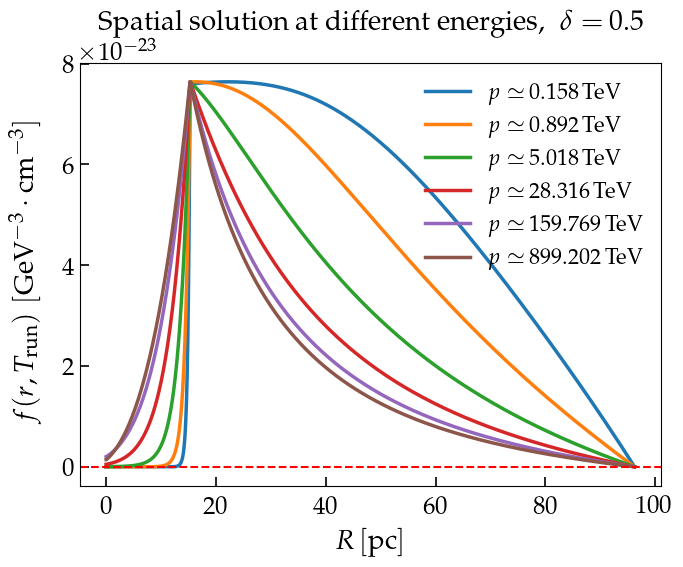

In [84]:
## Block to plot the spatial solution at different energies ##

plt.figure(figsize=(7.5, 5.5))
plot_cosmetics_single()



p_chosen_array = np.logspace(start=np.log10(p_grid[indx_p_inj]), stop=np.log10(p_grid[-1]-0.1*p_grid[-1]), num=6)
indices_p_chosen_array = [np.argmin( (abs(p_grid - p_chosen_array[ip])) ) for ip in range(len(p_chosen_array))]
multiplication_factor = [max(sol[-1, :, indices_p_chosen_array[0]]) / max(sol[-1, :, indices_p_chosen_array[ip+1]])  for ip in range(len(p_chosen_array)-1)]

 
for ip in range(len(p_chosen_array)):
    if ip == 0:
        plt.plot(x_grid*L_ref, CR_norm*sol[-1, :, indices_p_chosen_array[ip]], lw=2.5, label='$p \simeq \,$' + str( round(p_grid[indices_p_chosen_array[ip]]) / 1.e3 ) + '$\, \mathrm{TeV}$')
    else:
        plt.plot(x_grid*L_ref, multiplication_factor[ip-1]*CR_norm*sol[-1, :, indices_p_chosen_array[ip]], lw=2.5, label='$p \simeq \,$' + str( round(p_grid[indices_p_chosen_array[ip]]) / 1.e3 ) + '$\, \mathrm{TeV}$')
    
    
plt.axhline(y=0., ls='--', lw=1.5, color='red')
plt.title('Spatial solution at different energies, \;$\\delta = \,$' + str(delta_diff), fontsize=20, pad=8)
plt.xlabel('$R \, [\mathrm{pc}]$', fontsize=20)
plt.ylabel('$f(r, T_{\mathrm{run}}) \; [\mathrm{GeV^{-3}} \cdot \mathrm{cm^{-3}}]$', fontsize=20)
plt.legend(fontsize=16, frameon=False)

plt.savefig(dirName + 'SpatialSol_DifferentEnergies_delta=' + str(delta_diff) + '.pdf',format='pdf',bbox_inches='tight', dpi=200)

shock at index 386, location = 0.15897207177106154 = 15.300969635513361 [pc]

dimensionless locations where I am plotting the spectrum: 
[0.0, 0.03171204540510813, 0.06342409081021626, 0.09554798096084527, 0.1272600263659534, 0.15897207177106154, 0.3257026486018616, 0.49179806741169485, 0.658969755763111, 0.8261414441145272, 0.9933131324659432]


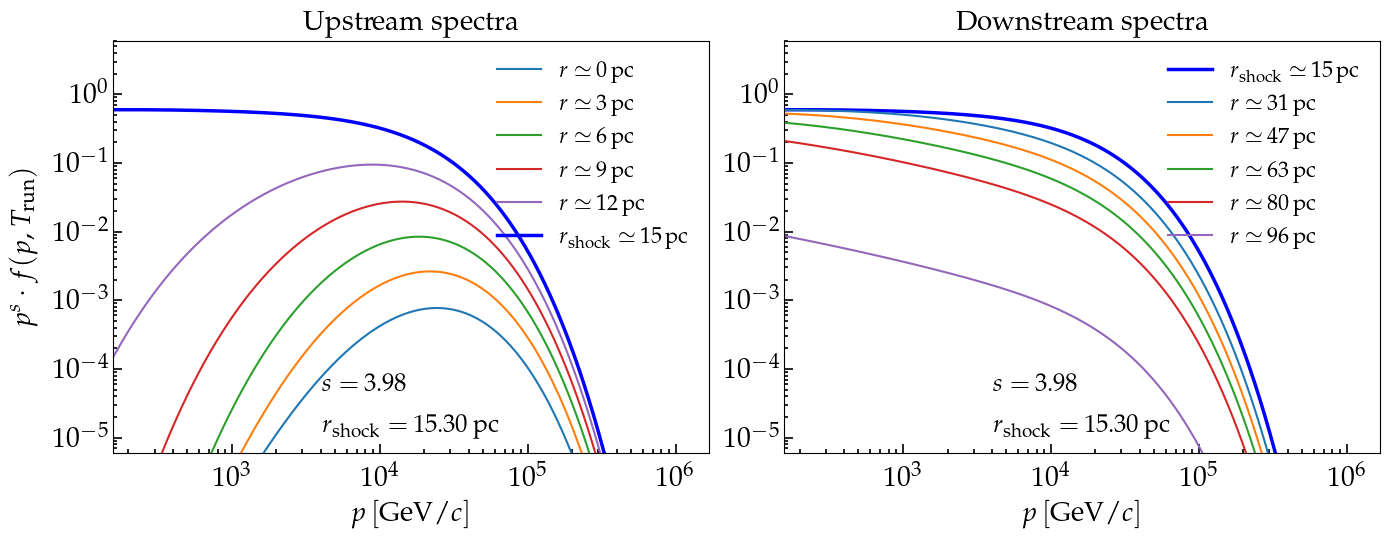

In [85]:
## Block to plot the spectrum at different locations ##


loc_spectrum_upstream = np.linspace(start=start_x_grid, stop=shock_location, num=5, endpoint=False)
loc_spectrum_downstream = np.linspace(start=x_grid[shock_index], stop=x_grid[-2], num=6, endpoint=True)
loc_spectrum = np.concatenate( (loc_spectrum_upstream, loc_spectrum_downstream) )
indx_spectrum = [np.argmin( abs(loc_spectrum[ix] - x_grid) ) for ix in range(len(loc_spectrum))]

print(f'shock at index {shock_index}, location = {shock_location} = {shock_location*L_ref} [pc]')
print('')
print(f'dimensionless locations where I am plotting the spectrum: \n{[x_grid[indx_spectrum[i]] for i in range(len(loc_spectrum))]}')


plt.figure(figsize=(14,5.5))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

for ix in range(len(loc_spectrum)):
    if loc_spectrum[ix] <= shock_location:
        if abs(loc_spectrum[ix] - shock_location) <= 1.e-2:
            plt.loglog(p_grid[:], (p_grid[:] / p_grid[0])**propagated_slope_fit * sol[-1, indx_spectrum[ix], :], ls='-', lw=2.5, color='blue', label='$r_{\mathrm{shock}} \simeq \,$' + str( round(loc_spectrum[ix]*L_ref) ) + '$\, \mathrm{pc}$')
        else:
            plt.loglog(p_grid[:], (p_grid[:] / p_grid[0])**propagated_slope_fit * sol[-1, indx_spectrum[ix], :], ls='-', lw=1.5, label='$r \simeq \,$' + str( round(loc_spectrum[ix]*L_ref) ) + '$\, \mathrm{pc}$')


plt.xlim(p_grid[indx_p_inj])
plt.ylim(np.max((p_grid[:] / p_grid[0])**propagated_slope_fit * sol[-1, :, :]) / 1.e5, np.max((p_grid[:]/p_grid[0])**propagated_slope_fit * sol[-1, :, :]) * 1.e1)
plt.title('Upstream spectra', fontsize=20, pad=8)
plt.xlabel('$p \, [\mathrm{GeV}/c]$', fontsize=20)
plt.ylabel('$p^s \cdot f(p,T_{\mathrm{run}})$', fontsize=20)
plt.text(0.35, 0.15, '$s = \,$' + str("{:.2f}".format(propagated_slope_fit)), fontsize=18, transform = plt.gca().transAxes)
plt.text(0.35, 0.05, '$r_{\mathrm{shock}} = \,$' + str("{:.2f}".format(shock_location*L_ref)) + '$\, \mathrm{pc}$', fontsize=18, transform = plt.gca().transAxes)
plt.legend(fontsize=16, frameon=False)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

for ix in range(len(loc_spectrum)):
    if loc_spectrum[ix] >= shock_location:
        if abs(loc_spectrum[ix] - shock_location) <= 1.e-2:
            plt.loglog(p_grid[:], (p_grid[:] / p_grid[0])**propagated_slope_fit * sol[-1, indx_spectrum[ix], :], ls='-', lw=2.5, color='blue', label='$r_{\mathrm{shock}} \simeq \,$' + str( round(loc_spectrum[ix]*L_ref) ) + '$\, \mathrm{pc}$')
        else:
            plt.loglog(p_grid[:], (p_grid[:] / p_grid[0])**propagated_slope_fit * sol[-1, indx_spectrum[ix], :], ls='-', lw=1.5, label='$r \simeq \,$' + str( round(loc_spectrum[ix]*L_ref) ) + '$\, \mathrm{pc}$')


plt.xlim(p_grid[indx_p_inj])
plt.ylim(np.max((p_grid[:] / p_grid[0])**propagated_slope_fit * sol[-1, :, :]) / 1.e5, np.max((p_grid[:]/p_grid[0])**propagated_slope_fit * sol[-1, :, :]) * 1.e1)
plt.title('Downstream spectra', fontsize=20, pad=8)
plt.xlabel('$p \, [\mathrm{GeV}/c]$', fontsize=20)
#plt.ylabel('$p^s \cdot f(p,T_{\mathrm{run}})$', fontsize=20)
plt.text(0.35, 0.15, '$s = \,$' + str("{:.2f}".format(propagated_slope_fit)), fontsize=18, transform = plt.gca().transAxes)
plt.text(0.35, 0.05, '$r_{\mathrm{shock}} = \,$' + str("{:.2f}".format(shock_location*L_ref)) + '$\, \mathrm{pc}$', fontsize=18, transform = plt.gca().transAxes)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()


plt.savefig(dirName + 'Spectrum_DifferentLocations_delta=' + str(delta_diff) + '.pdf',format='pdf',bbox_inches='tight', dpi=200)

In [86]:
## Block to save the results in text files ##

plotting_folder = '/Users/ottaviofornieri/PHYSICS_projects/GitProjects/StellarClusters/Stored_solutions/Plotting_Folder/'
internal_folder = plotting_folder + 'Np=' + str(Np) + '/'


try:
    # Create target Directory
    os.mkdir(internal_folder)
    print("Directory", internal_folder, "created")
    print("")
except FileExistsError:
    print("Directory", internal_folder, "already exists")
    print("")

    
    
for ix in range(len(loc_spectrum)):
    
    if delta_diff == 0.:
        
        if ix == 0:
            try:
                # Create target Directory
                os.mkdir(internal_folder + 'D-const/')
                print("Directory", internal_folder + 'D-const/', "created")
                print("")
            except FileExistsError:
                print("Directory", internal_folder + 'D-const/', "already exists")
                print("")
        
        data_txt_file = np.zeros( (1, len(p_grid)) )
        data_txt_file[0,:] = sol[-1, indx_spectrum[ix], :]
        if abs(loc_spectrum[ix] - shock_location) <= 1.e-2:
            np.savetxt(internal_folder + 'D-const/t-final_D-const_x=Shock.txt', data_txt_file)
            np.savetxt(dirName + 't-final_D-const_x=Shock.txt', data_txt_file)
        else:
            np.savetxt(internal_folder + 'D-const/t-final_D-const_x=' + str( round(loc_spectrum[ix]*L_ref) ) + 'pc.txt', data_txt_file)
            np.savetxt(dirName + 't-final_D-const_x=' + str( round(loc_spectrum[ix]*L_ref) ) + 'pc.txt', data_txt_file)

            
            
    elif delta_diff == 0.33:
        
        if ix == 0:
            try:
                # Create target Directory
                os.mkdir(internal_folder + 'D-Kol/')
                print("Directory", internal_folder + 'D-Kol/', "created")
                print("")
            except FileExistsError:
                print("Directory", internal_folder + 'D-Kol/', "already exists")
                print("")
        
        data_txt_file = np.zeros( (1, len(p_grid)) )
        data_txt_file[0,:] = sol[-1, indx_spectrum[ix], :]
        if abs(loc_spectrum[ix] - shock_location) <= 1.e-2:
            np.savetxt(internal_folder + 'D-Kol/t-final_D-Kol_x=Shock.txt', data_txt_file)
            np.savetxt(dirName + 't-final_D-Kol_x=Shock.txt', data_txt_file)
        else:
            np.savetxt(internal_folder + 'D-Kol/t-final_D-Kol_x=' + str( round(loc_spectrum[ix]*L_ref) ) + 'pc.txt', data_txt_file)
            np.savetxt(dirName + 't-final_D-Kol_x=' + str( round(loc_spectrum[ix]*L_ref) ) + 'pc.txt', data_txt_file)

            
    elif delta_diff == 0.5:
        
        if ix == 0:
            try:
                # Create target Directory
                os.mkdir(internal_folder + 'D-IK/')
                print("Directory", internal_folder + 'D-IK/', "created")
                print("")
            except FileExistsError:
                print("Directory", internal_folder + 'D-IK/', "already exists")
                print("")
        
        data_txt_file = np.zeros( (1, len(p_grid)) )
        data_txt_file[0,:] = sol[-1, indx_spectrum[ix], :]
        if abs(loc_spectrum[ix] - shock_location) <= 1.e-2:
            np.savetxt(internal_folder + 'D-IK/t-final_D-IK_x=Shock.txt', data_txt_file)
            np.savetxt(dirName + 't-final_D-IK_x=Shock.txt', data_txt_file)
        else:
            np.savetxt(internal_folder + 'D-IK/t-final_D-IK_x=' + str( round(loc_spectrum[ix]*L_ref) ) + 'pc.txt', data_txt_file)
            np.savetxt(dirName + 't-final_D-IK_x=' + str( round(loc_spectrum[ix]*L_ref) ) + 'pc.txt', data_txt_file)
            
            
    elif delta_diff == 1.:
        
        if ix == 0:
            try:
                # Create target Directory
                os.mkdir(internal_folder + 'D-Bohm/')
                print("Directory", internal_folder + 'D-Bohm/', "created")
                print("")
            except FileExistsError:
                print("Directory", internal_folder + 'D-Bohm/', "already exists")
                print("")
        
        data_txt_file = np.zeros( (1, len(p_grid)) )
        data_txt_file[0,:] = sol[-1, indx_spectrum[ix], :]
        if abs(loc_spectrum[ix] - shock_location) <= 1.e-2:
            np.savetxt(internal_folder + 'D-Bohm/t-final_D-Bohm_x=Shock.txt', data_txt_file)
            np.savetxt(dirName + 't-final_D-Bohm_x=Shock.txt', data_txt_file)
        else:
            np.savetxt(internal_folder + 'D-Bohm/t-final_D-Bohm_x=' + str( round(loc_spectrum[ix]*L_ref) ) + 'pc.txt', data_txt_file)
            np.savetxt(dirName + 't-final_D-Bohm_x=' + str( round(loc_spectrum[ix]*L_ref) ) + 'pc.txt', data_txt_file)

Directory /Users/ottaviofornieri/PHYSICS_projects/GitProjects/StellarClusters/Stored_solutions/Plotting_Folder/Np=4096/ already exists

Directory /Users/ottaviofornieri/PHYSICS_projects/GitProjects/StellarClusters/Stored_solutions/Plotting_Folder/Np=4096/D-IK/ already exists



## <center> Critical Radius for the wind
#### <center> Derived from the Parker's model of the solar wind
    
$$
r_c = \frac{G M_{\mathrm{cluster}}}{2 \, c_s^2}
$$

In [87]:
solar_mass = 1.988e30               # solar mass, in [kg]
gravitational_const = 6.6743e-11    # in [m^{3} kg^{-1} s^{-2}]

sound_speed_OB = 3.e2               # in [m s^{-1}]
mass_cluster = 1.e3                 # in solar masses units

r_critical = (gravitational_const * mass_cluster*solar_mass) / (2 * sound_speed_OB**2)   # result in [m]
r_critical_cm = r_critical * 1.e2   # result in [cm]
r_critical_pc = r_critical_cm * conv_cm_pc

print(f'radius of the termination shock = {R_TS} [pc]')
print(f'radius of the forward shock = {L_ref} [pc]')
print('')
print(f'critical radius for the wind velocity = {r_critical_pc} [pc]')

radius of the termination shock = 15.30096963551336 [pc]
radius of the forward shock = 96.24941956816512 [pc]

critical radius for the wind velocity = 23.88331512 [pc]


## <center> pp inelastic cross-section

In [88]:
# inelastic cross-section for proton energy in [GeV]; result in [mb]
def sigma_inel(Tp):

    Tp_th = 1.22              # threshold energy for the pi0 production, in [GeV]
    LX = np.log( Tp/Tp_th )
    Threshold = max( 0., 1. - ( Tp_th/Tp )**1.9 )

    if Tp >= Tp_th:
        return ( 30.7 - 0.96*LX + 0.18*LX**2. ) * Threshold**3.
    else:
        return 0.

    

def sigma_gamma(E_proj, E_gamma):
# result given in [mb / GeV]

    if E_gamma >= E_proj:
        return 0.
    
    proton_mass = m_p
    TeV = 1.e3
    E_p = E_proj
    L = np.log(E_p / TeV)     # defined in pag.9

    x = E_gamma / E_p         # defined in pag.9

    B_gamma = 1.30 + 0.14 * L + 0.011 * L**2              # Eq.(59)
    beta_gamma = 1. / (1.79 + 0.11 * L + 0.008 * L**2)    # Eq.(60)
    k_gamma = 1. / (0.801 + 0.049 * L + 0.014 * L**2)     # Eq.(61)
    x2beta = x**(beta_gamma)

    F_1 = (1. - x2beta) / (1. + k_gamma * x2beta * (1. - x2beta))
    F_2 = 4. * beta_gamma * x2beta / (1. - x2beta)
    F_3 = 4. * k_gamma * beta_gamma * x2beta * (1. - 2. * x2beta)
    F_3 = F_3 / ( 1. + k_gamma * x2beta * (1. - x2beta) )

    F_gamma = B_gamma * np.log(x) / x * F_1**4            # Eq.(58)
    F_gamma = F_gamma * (1. / np.log(x) - F_2 - F_3)

    return sigma_inel(E_p) * F_gamma / E_p



def F_gamma_func(E_proj, x_):

    proton_mass = m_p
    TeV = 1.e3
    E_p = E_proj
    L = np.log(E_p / TeV)     # defined in pag.9

    x = x_

    B_gamma = 1.30 + 0.14 * L + 0.011 * L**2              # Eq.(59)
    beta_gamma = 1. / (1.79 + 0.11 * L + 0.008 * L**2)    # Eq.(60)
    k_gamma = 1. / (0.801 + 0.049 * L + 0.014 * L**2)     # Eq.(61)
    x2beta = x**(beta_gamma)

    F_1 = (1. - x2beta) / (1. + k_gamma * x2beta * (1. - x2beta))
    F_2 = 4. * beta_gamma * x2beta / (1. - x2beta)
    F_3 = 4. * k_gamma * beta_gamma * x2beta * (1. - 2. * x2beta)
    F_3 = F_3 / ( 1. + k_gamma * x2beta * (1. - x2beta) )

    F_gamma = B_gamma * np.log(x) / x * F_1**4            # Eq.(58)
    F_gamma = F_gamma * (1. / np.log(x) - F_2 - F_3)

    return F_gamma

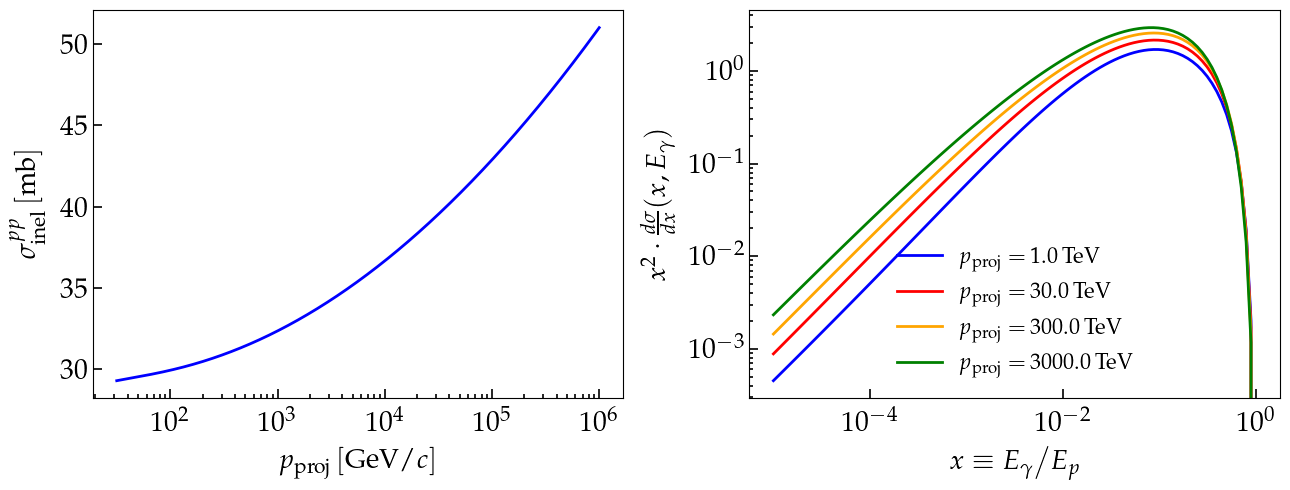

In [89]:
x_Xsec = np.logspace(start=-5., stop=-0., num=100)


plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)
plot_cosmetics_multi()

plt.plot(p_grid, [sigma_inel( p_grid[ip] ) for ip in range(len(p_grid))], lw=2., color='blue')
plt.xscale('log')
plt.xlabel('$p_{\mathrm{proj}} \, [\mathrm{GeV}/c]$', fontsize=20)
plt.ylabel('$\\sigma^{pp}_{\mathrm{inel}} \, [\mathrm{mb}]$', fontsize=20)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()


p_show_Xsec = [1.e3, 3.e4, 3.e5, 3.e6]
colors = ['blue', 'red', 'orange', 'green']
for ip in range( len(p_show_Xsec) ):
    plt.loglog(x_Xsec, [p_show_Xsec[ip] * x_Xsec[ix]**2 * sigma_gamma(p_show_Xsec[ip], p_show_Xsec[ip]*x_Xsec[ix]) for ix in range(len(x_Xsec))], color=colors[ip],  lw=2., label='$p_\mathrm{proj} = \,$' + str(p_show_Xsec[ip]/1.e3) + '$\, \mathrm{TeV}$')
    
    
plt.xlabel('$x \equiv E_{\gamma} \\big/ E_{p}$', fontsize=20)
plt.ylabel('$x^2 \cdot \\frac{d \\sigma}{dx}(x, E_\gamma) $', fontsize=20)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()

## <center> Emissivity $\epsilon_\gamma$
    
$$
\begin{aligned}
\bullet \quad &\epsilon_\gamma (E_\gamma, r) \simeq c \, n_{\mathrm{gas}}(r) \ln A \cdot \sum_i E_{p,i} n_{p,i}(r) \cdot \frac{d \sigma_{pp}}{dE_\gamma}(E_{p,i}, E_\gamma) = \left[ \frac{1}{\mathrm{GeV \cdot s \cdot cm^3}} \right] \\
&F(y) = 2 \int_{|y|}^{+\infty} \frac{r \, dr}{\sqrt{r^2 - y^2}} \cdot f(r) \qquad \qquad \textrm{profile projected onto the skymap} \\
\bullet \quad &\Phi_\gamma (E_\gamma) = \frac{\int_0^{y_{\mathrm{max}}} F(y, E_\gamma) y \, dy}{2 \, d^2_{\mathrm{cluster}}} \qquad \qquad \quad y_{\mathrm{max}} \equiv \textrm{Fermi/HAWC integration region} = 55 \, \mathrm{pc}
\end{aligned}
$$

the integration to compute the gamma-rays is done up to index 1115, i.e.: 55.05856395970689 [pc]

It took 8.963825999999244 seconds


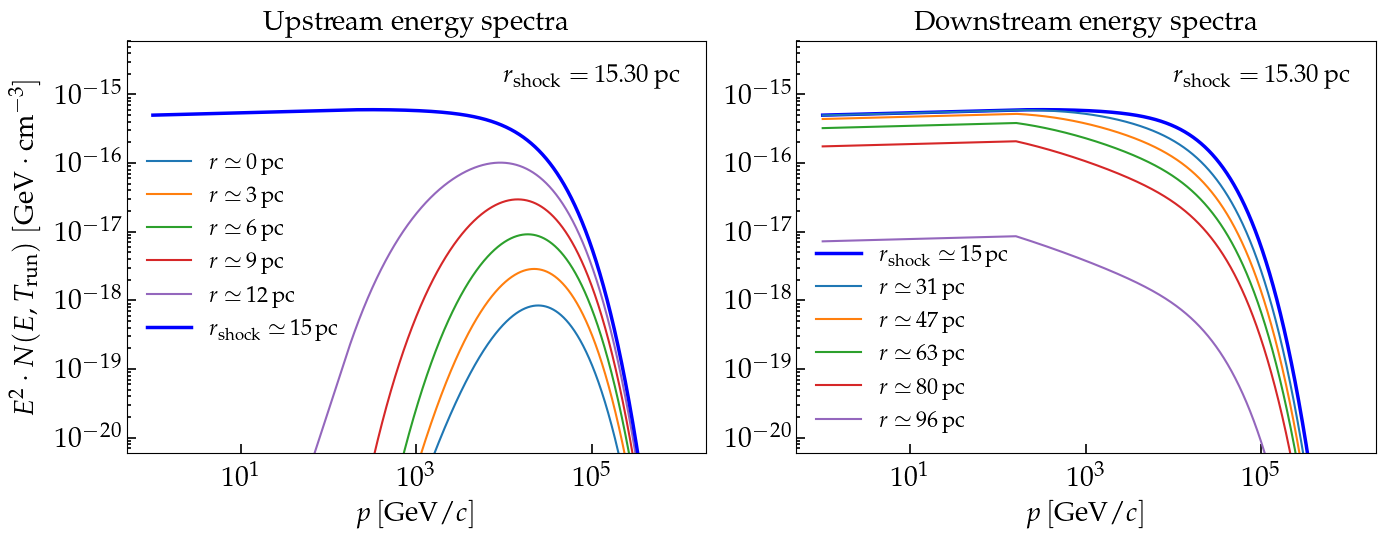

In [99]:
d_cluster = 1.4                       # in [kpc]
d_cluster_cm = d_cluster * 1.e3 * conv_pc_cm
radius_gammaray_integration = 55.     # in [pc], integration radius considered by HAWC&Fermi
x_grid_pc = x_grid * L_ref
indx_radius_gammaray_integration = np.argmin( abs(radius_gammaray_integration - x_grid_pc) )
print(f'the integration to compute the gamma-rays is done up to index {indx_radius_gammaray_integration}, i.e.: {x_grid_pc[indx_radius_gammaray_integration]} [pc]')
print('')


log_A = np.log(factor_grid[0])
E_gamma = np.logspace(start=0., stop=np.log10( max(p_grid)/10. ), num=200)    # where we want to see the gamma rays


summation = np.zeros( (len(x_grid), len(E_gamma)) )
emissivity_gamma = np.zeros( (len(x_grid), len(E_gamma)) )
emissivity_gamma_rsquared = np.zeros( (len(x_grid), len(E_gamma)) )
Flux_gamma = np.zeros( len(E_gamma) )



n_p_PhSp = np.zeros( (len(x_grid), len(p_array_integral_tot)) )
n_p = np.zeros( (len(x_grid), len(p_array_integral_tot)) )
n_p_PhSp = CR_spectrum * CR_norm
for ix in range(len(x_grid)):
    n_p[ix, :] = [4 * np.pi * p_array_integral_tot[ip]**2 * n_p_PhSp[ix, ip] for ip in range(len(p_array_integral_tot))]

    

plt.figure(figsize=(14, 5.5))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

for ix in range(len(loc_spectrum)):
    if loc_spectrum[ix] <= shock_location:
        if abs(loc_spectrum[ix] - shock_location) <= 1.e-2:
            plt.loglog(p_array_integral_tot[:], (p_array_integral_tot[:] / p_grid[0])**2. * n_p[indx_spectrum[ix], :], ls='-', lw=2.5, color='blue', label='$r_{\mathrm{shock}} \simeq \,$' + str( round(loc_spectrum[ix]*L_ref) ) + '$\, \mathrm{pc}$')
        else:
            plt.loglog(p_array_integral_tot[:], (p_array_integral_tot[:] / p_grid[0])**2. * n_p[indx_spectrum[ix], :], ls='-', lw=1.5, label='$r \simeq \,$' + str( round(loc_spectrum[ix]*L_ref) ) + '$\, \mathrm{pc}$')

    

plt.ylim(np.max((p_array_integral_tot[:] / p_grid[0])**2 * n_p[:, :]) / 1.e5, np.max((p_array_integral_tot[:]/p_grid[0])**2 * n_p[:, :]) * 1.e1)
plt.title('Upstream energy spectra', fontsize=20, pad=8)
plt.xlabel('$p \, [\mathrm{GeV}/c]$', fontsize=20)
plt.ylabel('$E^2 \cdot N(E,T_{\mathrm{run}}) \; [\mathrm{GeV \cdot cm^{-3}}]$', fontsize=20)
plt.text(0.65, 0.9, '$r_{\mathrm{shock}} = \,$' + str("{:.2f}".format(shock_location*L_ref)) + '$\, \mathrm{pc}$', fontsize=18, transform = plt.gca().transAxes)
plt.legend(fontsize=16, frameon=False)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

for ix in range(len(loc_spectrum)):
    if loc_spectrum[ix] >= shock_location:
        if abs(loc_spectrum[ix] - shock_location) <= 1.e-2:
            plt.loglog(p_array_integral_tot[:], (p_array_integral_tot[:] / p_grid[0])**2. * n_p[indx_spectrum[ix], :], ls='-', lw=2.5, color='blue', label='$r_{\mathrm{shock}} \simeq \,$' + str( round(loc_spectrum[ix]*L_ref) ) + '$\, \mathrm{pc}$')
        else:
            plt.loglog(p_array_integral_tot[:], (p_array_integral_tot[:] / p_grid[0])**2. * n_p[indx_spectrum[ix], :], ls='-', lw=1.5, label='$r \simeq \,$' + str( round(loc_spectrum[ix]*L_ref) ) + '$\, \mathrm{pc}$')

    

plt.ylim(np.max((p_array_integral_tot[:] / p_grid[0])**2 * n_p[:, :]) / 1.e5, np.max((p_array_integral_tot[:]/p_grid[0])**2 * n_p[:, :]) * 1.e1)
plt.title('Downstream energy spectra', fontsize=20, pad=8)
plt.xlabel('$p \, [\mathrm{GeV}/c]$', fontsize=20)
#plt.ylabel('$E^2 \cdot N(E,T_{\mathrm{run}}) \; [\mathrm{GeV \cdot cm^{-3}}]$', fontsize=20)
plt.text(0.65, 0.9, '$r_{\mathrm{shock}} = \,$' + str("{:.2f}".format(shock_location*L_ref)) + '$\, \mathrm{pc}$', fontsize=18, transform = plt.gca().transAxes)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()

    

start = time.process_time()


'''
# volume integration
####################
for ig in range( len(E_gamma) ):
    # result in [GeV^{-1} s^{-1} cm^{-3}]
    summation[:, ig] = sum( [p_array_integral_tot[ip] * n_p[:, ip] * sigma_gamma(p_array_integral_tot[ip], E_gamma[ig])*conv_mbarn_cm2 for ip in range( len(p_array_integral_tot) )] )
    emissivity_gamma[:, ig] = c_cm * n_ISM_array[:] * log_A * summation[:, ig]
    emissivity_gamma_rsquared[:, ig] = emissivity_gamma[:, ig] * ( x_grid[:]*L_ref*conv_pc_cm )**2


for ig in range( len(E_gamma) ):
    # result given in [s^{-1} cm^{-2} GeV^{-1}]
    Flux_gamma[ig] = np.trapz( emissivity_gamma_rsquared[:indx_radius_gammaray_integration, ig], (x_grid[:indx_radius_gammaray_integration]*L_ref*conv_pc_cm), axis=-1 ) / (d_cluster_cm)**2
####################
'''



# integration along the LoS
###########################
for ig in range( len(E_gamma) ):
    # result in [GeV^{-1} s^{-1} pc^{-3}]
    summation[:, ig] = sum( [p_array_integral_tot[ip] * n_p[:, ip] * sigma_gamma(p_array_integral_tot[ip], E_gamma[ig])*conv_mbarn_cm2 for ip in range( len(p_array_integral_tot) )] )
    emissivity_gamma[:, ig] = c_cm * n_ISM_array[:] * log_A * summation[:, ig] / (conv_cm_pc**3)
    


GammaFlux_array = np.linspace(start=0., stop=x_grid_pc[indx_radius_gammaray_integration], num=100)
integral_over_r = np.zeros( len(GammaFlux_array) )
Flux_gamma = np.zeros( len(E_gamma) )

for ig in range( len(E_gamma) ):
    
    for ir in range( len(GammaFlux_array) ):

        ir_indx_x_grid = np.argmin( abs(GammaFlux_array[ir] - x_grid_pc) )
        n_decades_LoS = round( (L_ref - GammaFlux_array[ir]) / 10. )
        n_PointsPerDecade = 5
        Fy_LoS_array = np.linspace(start=GammaFlux_array[ir]+0.01, stop=L_ref, num=n_decades_LoS * n_PointsPerDecade)
        
        integral_over_r[ir] = 2 * np.trapz( Fy_LoS_array / np.sqrt(Fy_LoS_array**2 - GammaFlux_array[ir]**2) * emissivity_gamma[ir_indx_x_grid, ig], Fy_LoS_array, axis=-1 )
        
    Flux_gamma[ig] = np.trapz( integral_over_r * GammaFlux_array, GammaFlux_array, axis=-1 ) / (2 * d_cluster_cm**2)
###########################

    
time_emissivity = time.process_time() - start
print ('It took', time_emissivity, "seconds")

plt.savefig(dirName + 'EnergySpectrum_DifferentLocations_delta=' + str(delta_diff) + '.pdf',format='pdf',bbox_inches='tight', dpi=200)

len(data): 13



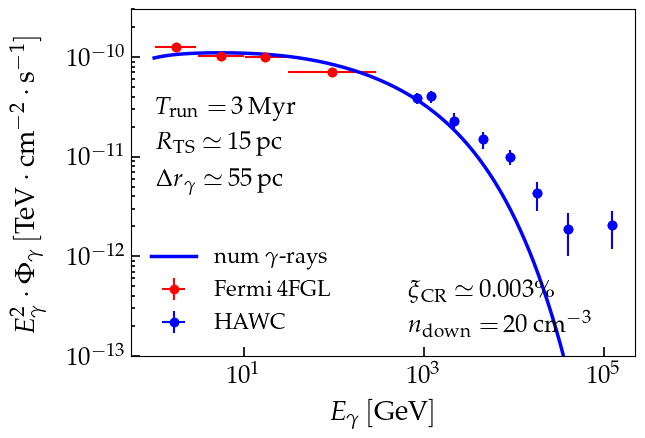

In [107]:
from numbers_parser import Document

doc_path = '/Users/ottaviofornieri/PHYSICS_projects/GitProjects/StellarClusters/Data/'
doc = Document(doc_path + 'Fermi+HAWC.numbers')


sheets = doc.sheets
tables = sheets[0].tables
data = tables[0].rows(values_only=True)
df = pd.DataFrame(data[1:], columns=data[0])

print('len(data):', len(data))
print('')


E_mean_Fermi = np.zeros( 4 )
E_low_Fermi = np.zeros( 4 )
E_up_Fermi = np.zeros( 4 )
E_mean_HAWC = np.zeros( 8 )

Flux_Fermi_mean = np.zeros( 4 )
Flux_HAWC_mean = np.zeros( 8 )
Flux_HAWC_low = np.zeros( 8 )
Flux_HAWC_up = np.zeros( 8 )

E_mean_Fermi[:] = [ data[ie][1] for ie in range(1, 5) ]
E_mean_HAWC[:] = [ data[ie][1] for ie in range(5, len(data)) ]
E_low_Fermi[:] = [ data[ie][2] for ie in range(1, 5) ]
E_up_Fermi[:] = [ data[ie][3] for ie in range(1, 5) ]
Flux_Fermi_mean[:] = [ data[ie][4] for ie in range(1, 5) ]
Flux_HAWC_mean[:] = [ data[ie][4] for ie in range(5, len(data)) ]
Flux_HAWC_low[:] = [ data[ie][5] for ie in range(5, len(data)) ]
Flux_HAWC_up[:] = [ data[ie][6] for ie in range(5, len(data)) ]



plt.figure(figsize=(6.5,4.5))
plot_cosmetics_single()


plt.plot(E_mean_Fermi, Flux_Fermi_mean, 'ro')
plt.plot(E_mean_HAWC, Flux_HAWC_mean, 'bo')
plt.errorbar(E_mean_Fermi, Flux_Fermi_mean, fmt='ro', label='Fermi 4FGL', xerr=[E_mean_Fermi-E_low_Fermi, E_up_Fermi-E_mean_Fermi], yerr=0., ecolor='red')
plt.errorbar(E_mean_HAWC, Flux_HAWC_mean, fmt='bo', label='HAWC', xerr=0., yerr=[Flux_HAWC_mean-Flux_HAWC_low, Flux_HAWC_up-Flux_HAWC_mean], ecolor='blue')

plt.loglog(E_gamma, E_gamma**2. * 0.25*Flux_gamma, lw=2.5, color='blue', label='num $\gamma$-rays')
plt.ylim(1.e-13, 3.e-10)
plt.text(0.05, 0.7, '$T_{\mathrm{run}} = \,$' + str("{:.0f}".format(t_true)) + '$\, \mathrm{Myr}$', fontsize=18, transform = plt.gca().transAxes)
plt.text(0.05, 0.6, '$R_{\mathrm{TS}} \simeq \,$' + str(round(R_TS)) + '$\, \mathrm{pc}$', fontsize=18, transform = plt.gca().transAxes)
plt.text(0.05, 0.49, '$\\Delta r_{\gamma} \simeq \,$' + str(round(x_grid_pc[indx_radius_gammaray_integration])) + '$\, \mathrm{pc}$', fontsize=18, transform = plt.gca().transAxes)
plt.text(0.55, 0.17, '$\\xi_{\mathrm{CR}} \simeq \,$' + str("{:.3f}".format(xi_CR*100.)) + '\%', fontsize=18, transform = plt.gca().transAxes)
plt.text(0.55, 0.07, '$n_{\mathrm{down}} = \,$' + str("{:.0f}".format(n_ISM)) + '$\, \mathrm{cm^{-3}}$', fontsize=18, transform = plt.gca().transAxes)
plt.xlabel('$E_\gamma \, [\mathrm{GeV}]$', fontsize=20)
plt.ylabel('$E_\gamma^2 \cdot \Phi_\gamma \, [\mathrm{TeV \cdot cm^{-2} \cdot s^{-1}}]$', fontsize=20)
plt.legend(fontsize=16, frameon=False, loc='lower left')

plt.savefig(dirName + 'GammaRay_Spectrum_delta=' + str(delta_diff) + '.pdf',format='pdf',bbox_inches='tight', dpi=200)